# Post hoc calibration by Temperature and Platt scaling of the Perch v2 model on BirdSet

In [8]:
from matplotlib import pyplot as plt


plt.style.use("seaborn-v0_8")

In [9]:
from uncertainbird.utils.misc import load_data
from uncertainbird.modules.models.perchv2 import Perchv2Model

log_dir = "/workspace/logs/predictions/perch_v2"
data, predictions, targets, valid_keys = load_data(log_dir, load_logits=True)
model = Perchv2Model()
model_name = 'Perch v2'

Loaded data with 12000 samples
Predictions shape: torch.Size([12000, 9736])
Targets shape: torch.Size([12000, 9736])
Loaded data with 539 samples
Predictions shape: torch.Size([539, 9736])
Targets shape: torch.Size([539, 9736])
Loaded data with 24480 samples
Predictions shape: torch.Size([24480, 9736])
Targets shape: torch.Size([24480, 9736])
Loaded data with 15120 samples
Predictions shape: torch.Size([15120, 9736])
Targets shape: torch.Size([15120, 9736])
Loaded data with 4560 samples
Predictions shape: torch.Size([4560, 9736])
Targets shape: torch.Size([4560, 9736])
Loaded data with 23756 samples
Predictions shape: torch.Size([23756, 9736])
Targets shape: torch.Size([23756, 9736])
Loaded data with 205200 samples
Predictions shape: torch.Size([205200, 9736])
Targets shape: torch.Size([205200, 9736])
Loaded data with 36637 samples
Predictions shape: torch.Size([36637, 9736])
Targets shape: torch.Size([36637, 9736])


2025-10-20 08:58:06.720039: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/workspace/.venv/lib/python3.10/site-packages/tensorflow_hub/__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version
I0000 00:00:1760950700.160726 1247329 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22282 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:25:00.0, compute capability: 8.9


In [10]:
from uncertainbird.utils.misc import prune_non_target_classes

data = prune_non_target_classes(data, targets)

# Temperature scaling on POW validation set

In [11]:
from uncertainbird.utils.temperature_scaling import (
    fit_global_temperature,
    apply_temperature_scaling,
)
class_index = 10
data_POW = data

# compute global temperature value based on POW
temperature = fit_global_temperature(
    data_POW["POW"]["logits"], data_POW["POW"]["targets"], 1000, lr=0.001
)

print(f"Optimal temperature: {temperature:.3f}")

# apply temperature scaling to all test datasets
for dataset_name in valid_keys:

    data_POW[dataset_name]["predictions_ts"] = apply_temperature_scaling(
        data_POW[dataset_name]["logits"], temperature, model= model
    )

Optimal temperature: 3.280


Dataset: HSN
Before temperature scaling:


/workspace/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in macro-average
  warnings.warn(*args, **kwargs)  # noqa: B028
/workspace/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Accuracy: tensor(0.9988)
cmAP: tensor(0.5075)
Precision: tensor(0.0267)
Recall: tensor(0.0042)
F1 Score: tensor(0.0068)
AUROC: tensor(0.0454)
ECE: tensor(0.0011)
ECE Weighted: tensor(0.1089)
ECE Top-3: tensor(0.1095)
ECE Top-5: tensor(0.0814)
ECE Top-10: tensor(0.0441)
ECE Top-21: tensor(0.0215)
Miscalibration Score (MCS): tensor(-0.1088)
ECE Under-confidence: tensor(0.1089)
ECE Over-confidence: tensor(5.1377e-05)
After temperature scaling:
Accuracy: tensor(0.9987)
cmAP: tensor(0.5325)
Precision: tensor(0.0049)
Recall: tensor(4.7164e-05)
F1 Score: tensor(9.3090e-05)
AUROC: tensor(0.0455)
ECE: tensor(0.0028)
ECE Weighted: tensor(0.0945)
ECE Top-3: tensor(0.0858)
ECE Top-5: tensor(0.0633)
ECE Top-10: tensor(0.0512)
ECE Top-21: tensor(0.0409)
Miscalibration Score (MCS): tensor(-0.0849)
ECE Under-confidence: tensor(0.0897)
ECE Over-confidence: tensor(0.0048)
Dataset: NBP
Before temperature scaling:
Accuracy: tensor(0.9966)
cmAP: tensor(0.6564)
Precision: tensor(0.1035)
Recall: tensor(0.023

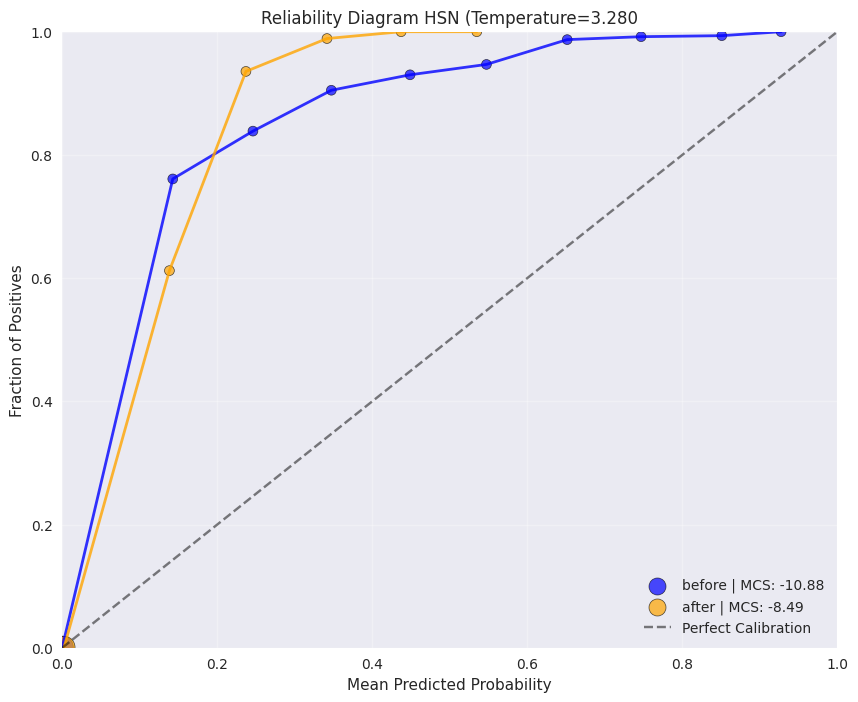

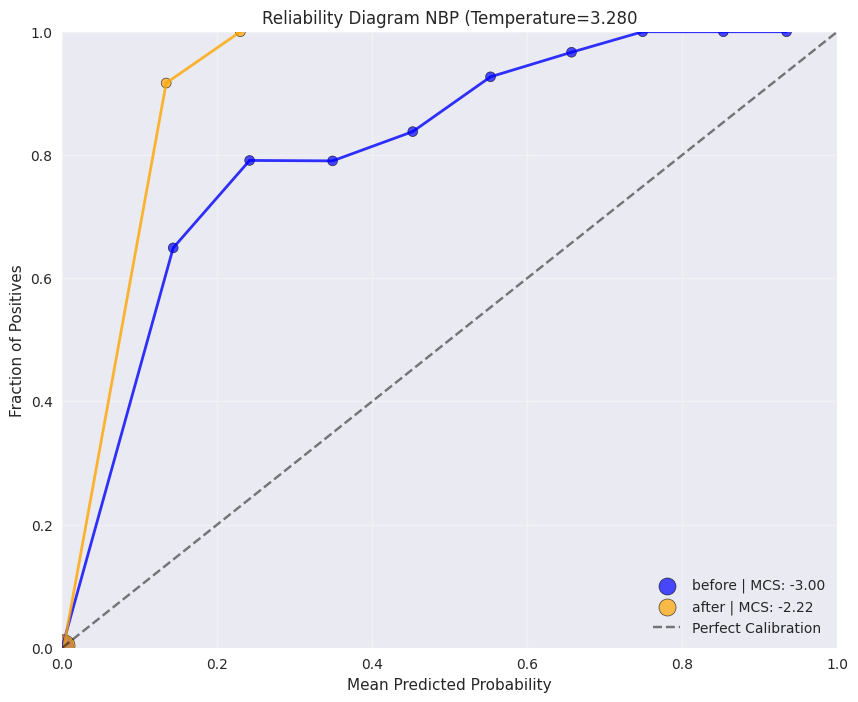

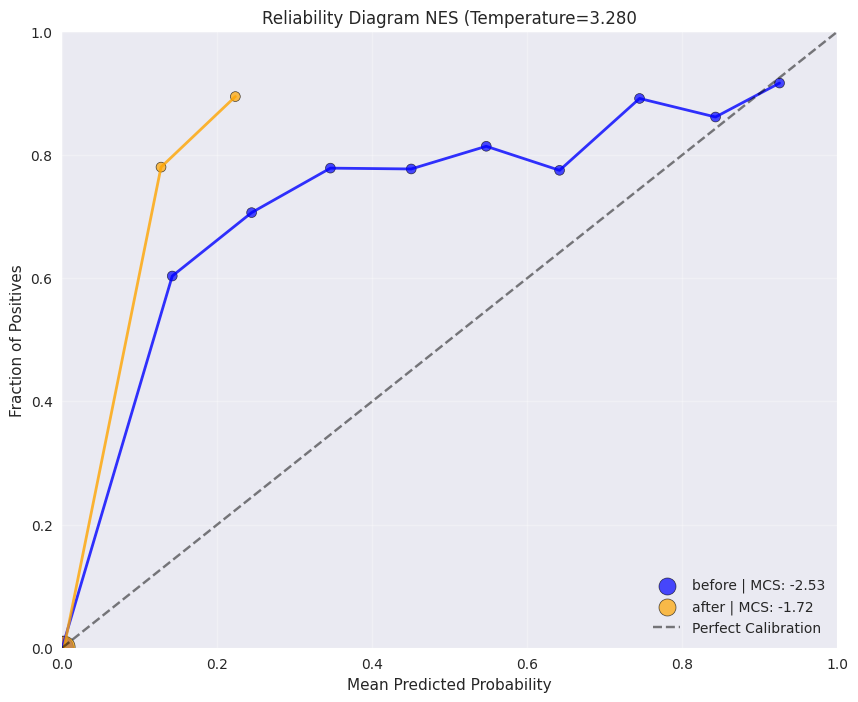

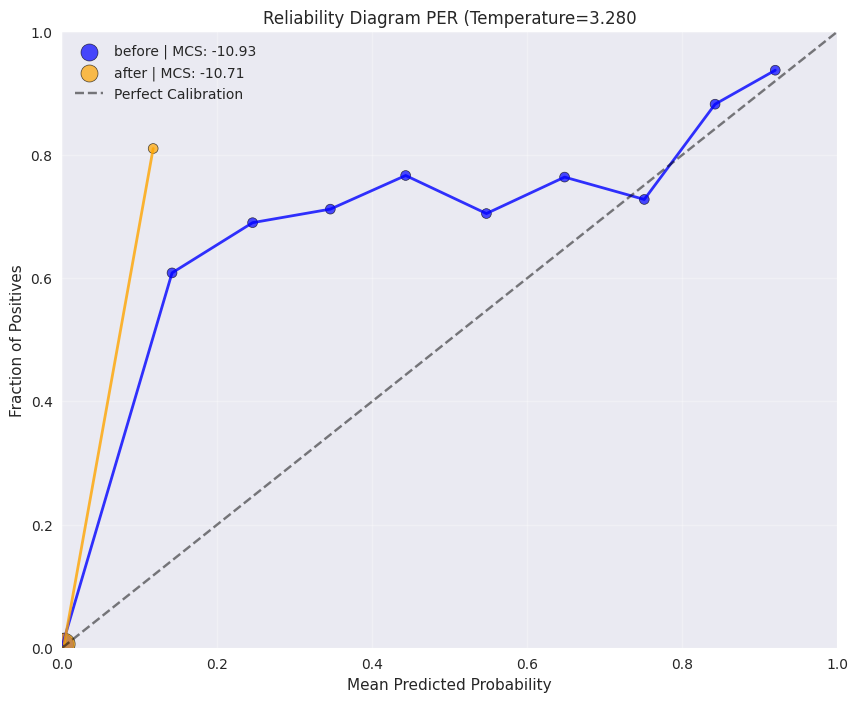

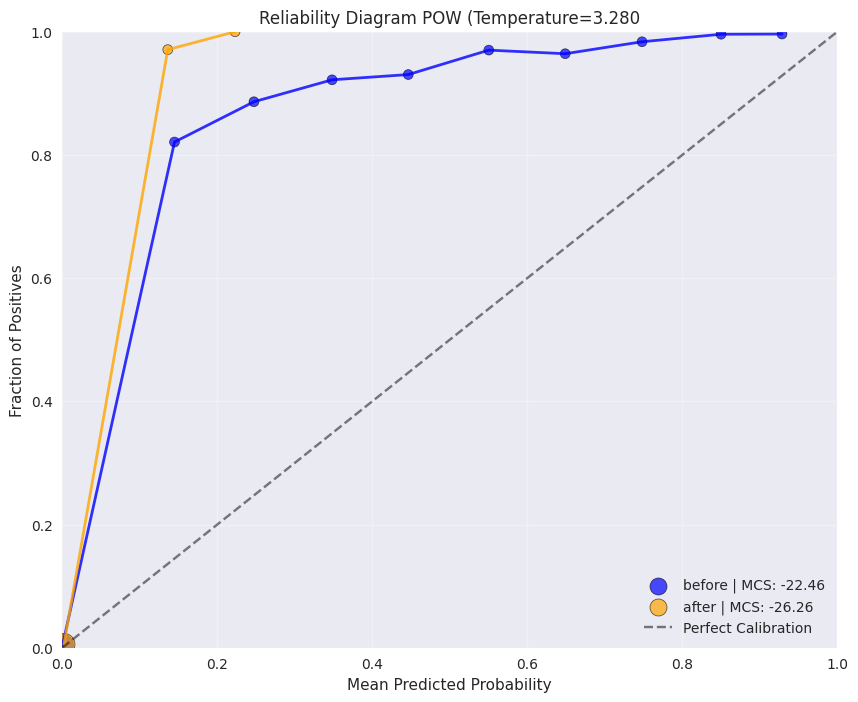

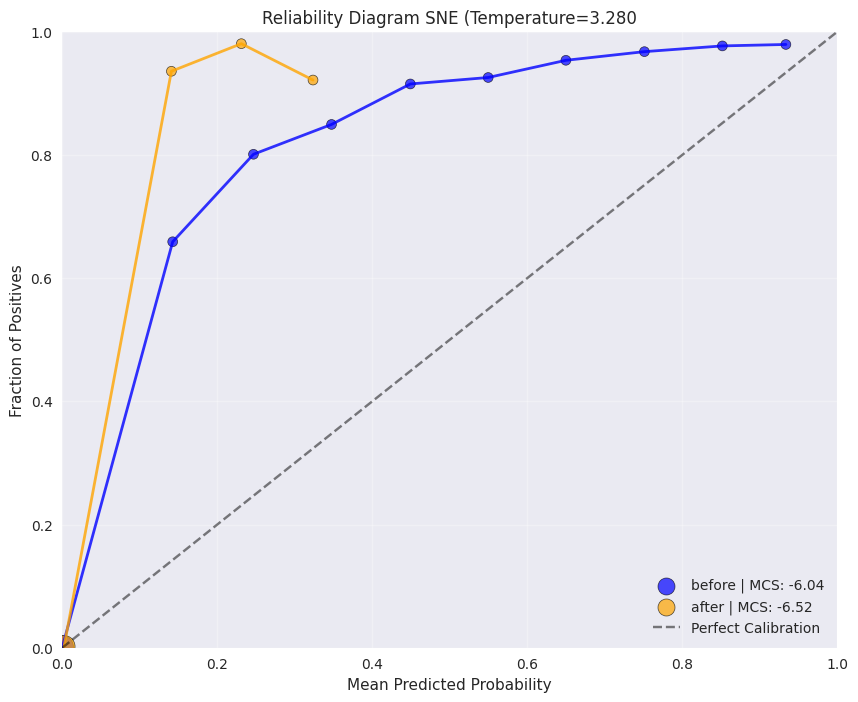

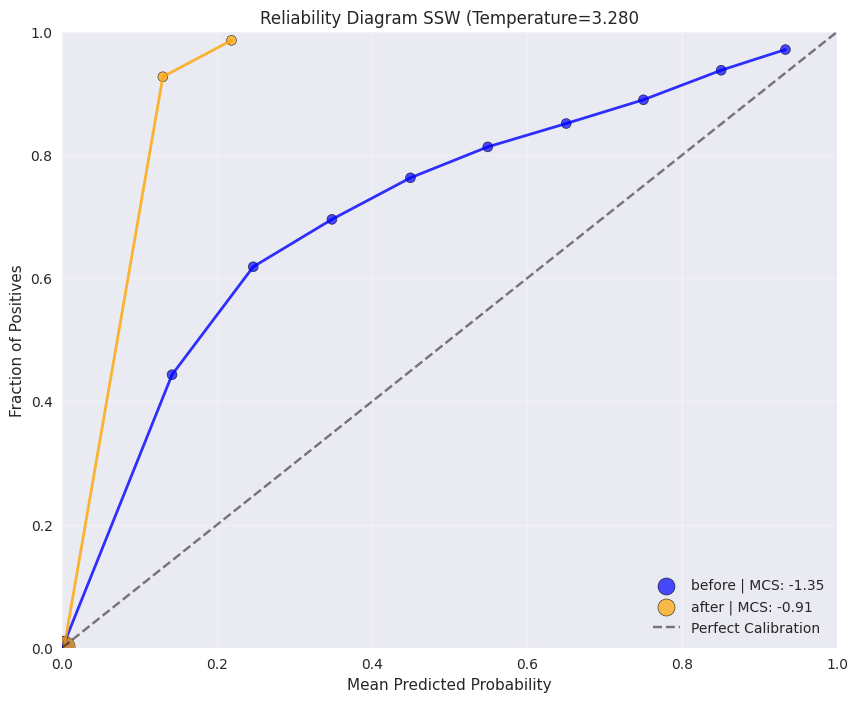

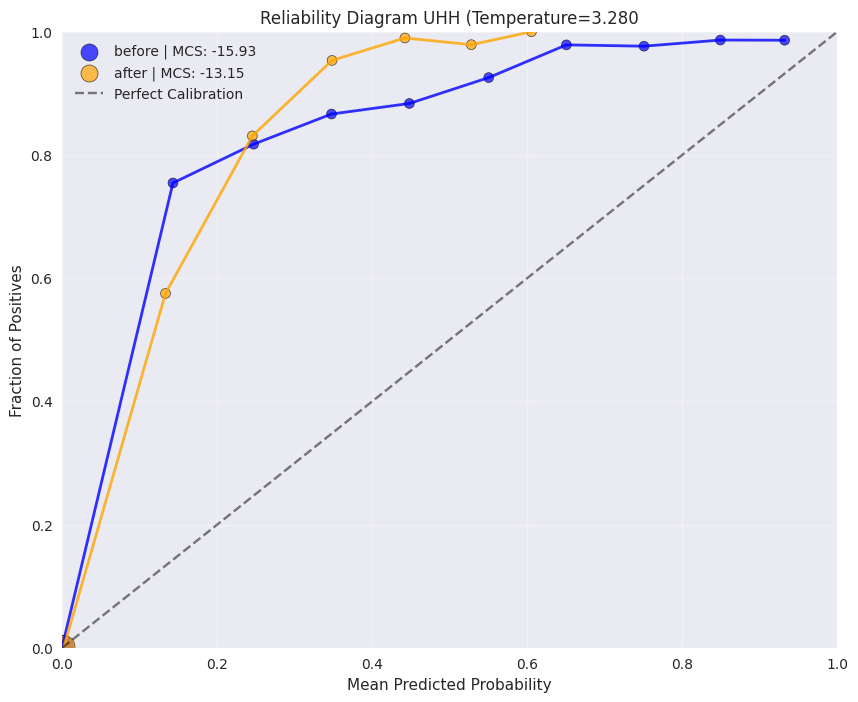

In [12]:
# compute metrics for HSN_test after temperature scaling
from uncertainbird.utils.plotting import (
    plot_combined_reliability_diagram,
    print_metrics,
)


for dataset_name in valid_keys:
    print("Dataset:", dataset_name)
    print("Before temperature scaling:")
    data_POW[dataset_name]["metrics"] = print_metrics(
        data_POW[dataset_name]["predictions"], data_POW[dataset_name]["targets"]
    )
    print("After temperature scaling:")
    data_POW[dataset_name]["metrics_ts"] = print_metrics(
        data_POW[dataset_name]["predictions_ts"], data_POW[dataset_name]["targets"]
    )
    # reliability diagram after temperature scaling including before and after
    combined_data = {
        "before": {
            "predictions": data_POW[dataset_name]["predictions"],
            "targets": data_POW[dataset_name]["targets"],
            "color": "blue",
            "metrics": data_POW[dataset_name]["metrics"],
        },
        "after": {
            "predictions": data_POW[dataset_name]["predictions_ts"],
            "targets": data_POW[dataset_name]["targets"],
            "color": "orange",
            "metrics": data_POW[dataset_name]["metrics_ts"],
        },
    }
    plot_combined_reliability_diagram(
        combined_data,
        n_bins=10,
        title=f"Reliability Diagram {dataset_name} (Temperature={temperature:.3f}",
    )

# Platt scaling on POW validation set

In [ ]:
from uncertainbird.utils.temperature_scaling import (
    fit_global_platt_scaling,
    apply_platt_scaling
)
class_index = 10
data_POW = data

# compute global temperature value based on POW
slope, bias = fit_global_platt_scaling(
    data_POW["POW"]["logits"], data_POW["POW"]["targets"], 1000, lr=0.01
)

print(f"Optimal slope: {slope:.3f}, bias: {bias:.3f}")

# apply temperature scaling to all test datasets
for dataset_name in valid_keys:

    data_POW[dataset_name]["predictions_ts"] = apply_platt_scaling(
        data_POW[dataset_name]["logits"], slope, bias, model= model
    )

Optimal slope: 1.257, bias: -10.923


Dataset: HSN
Before platt scaling:
Accuracy: tensor(0.9988)
cmAP: tensor(0.5075)
Precision: tensor(0.0267)
Recall: tensor(0.0042)
F1 Score: tensor(0.0068)
AUROC: tensor(0.0454)
ECE: tensor(0.0011)
ECE Weighted: tensor(0.1089)
ECE Top-3: tensor(0.1095)
ECE Top-5: tensor(0.0814)
ECE Top-10: tensor(0.0441)
ECE Top-21: tensor(0.0215)
Miscalibration Score (MCS): tensor(-0.1088)
ECE Under-confidence: tensor(0.1089)
ECE Over-confidence: tensor(5.1377e-05)
After temperature scaling:
Accuracy: tensor(0.9990)
cmAP: tensor(0.4881)
Precision: tensor(0.0224)
Recall: tensor(0.0234)
F1 Score: tensor(0.0182)
AUROC: tensor(0.0415)
ECE: tensor(0.0020)
ECE Weighted: tensor(0.0470)
ECE Top-3: tensor(0.0430)
ECE Top-5: tensor(0.0356)
ECE Top-10: tensor(0.0424)
ECE Top-21: tensor(0.0393)
Miscalibration Score (MCS): tensor(-0.0320)
ECE Under-confidence: tensor(0.0395)
ECE Over-confidence: tensor(0.0075)
Dataset: NBP
Before platt scaling:
Accuracy: tensor(0.9966)
cmAP: tensor(0.6564)
Precision: tensor(0.1035)

Accuracy: tensor(0.9992)
cmAP: tensor(0.4525)
Precision: tensor(0.1339)
Recall: tensor(0.0420)
F1 Score: tensor(0.0553)
AUROC: tensor(0.1877)
ECE: tensor(0.0007)
ECE Weighted: tensor(0.0137)
ECE Top-3: tensor(0.0288)
ECE Top-5: tensor(0.0238)
ECE Top-10: tensor(0.0154)
ECE Top-21: tensor(0.0099)
Miscalibration Score (MCS): tensor(-0.0135)
ECE Under-confidence: tensor(0.0136)
ECE Over-confidence: tensor(0.0001)
After temperature scaling:
Accuracy: tensor(0.9992)
cmAP: tensor(0.4165)
Precision: tensor(0.0904)
Recall: tensor(0.0834)
F1 Score: tensor(0.0731)
AUROC: tensor(0.1752)
ECE: tensor(0.0016)
ECE Weighted: tensor(0.0110)
ECE Top-3: tensor(0.0156)
ECE Top-5: tensor(0.0116)
ECE Top-10: tensor(0.0134)
ECE Top-21: tensor(0.0100)
Miscalibration Score (MCS): tensor(0.0018)
ECE Under-confidence: tensor(0.0046)
ECE Over-confidence: tensor(0.0064)
Dataset: UHH
Before platt scaling:
Accuracy: tensor(0.9976)
cmAP: tensor(0.3671)
Precision: tensor(0.0169)
Recall: tensor(0.0016)
F1 Score: tensor

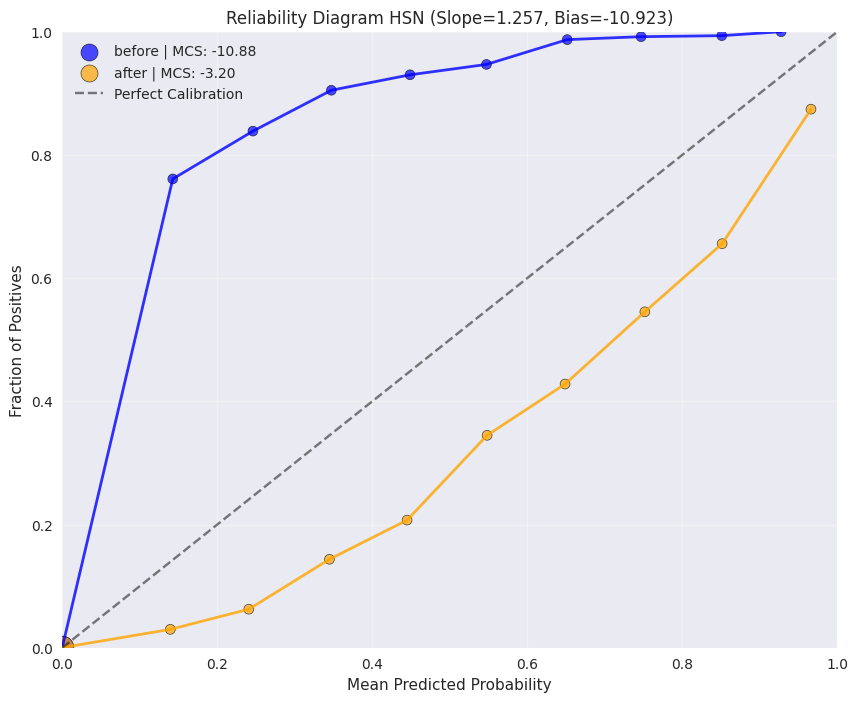

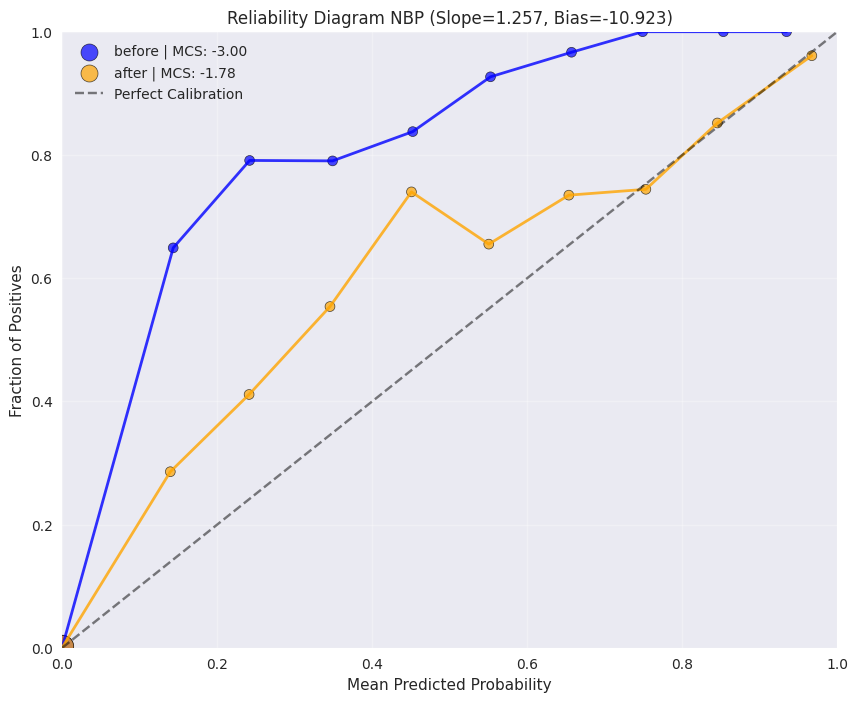

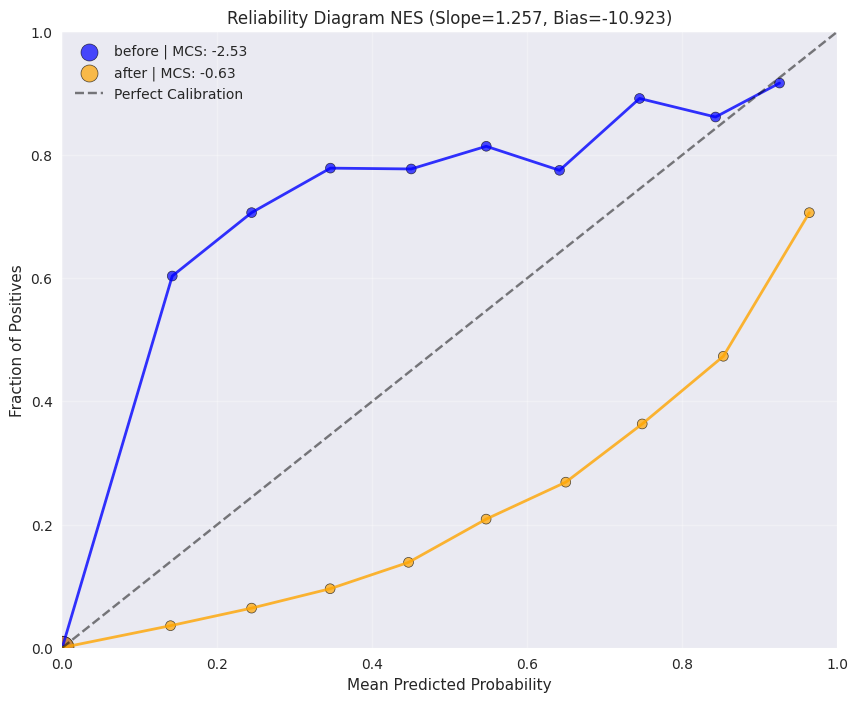

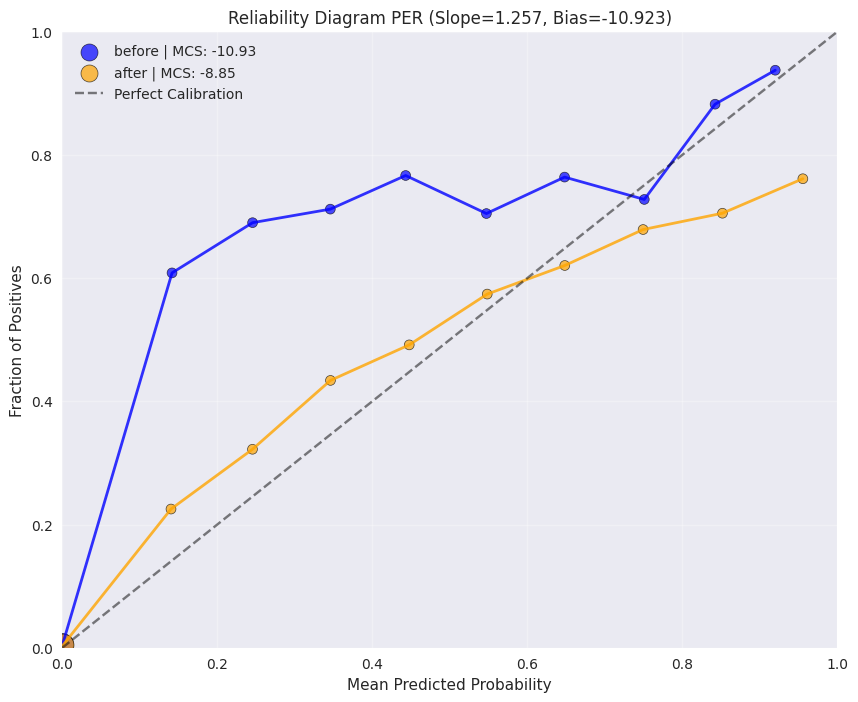

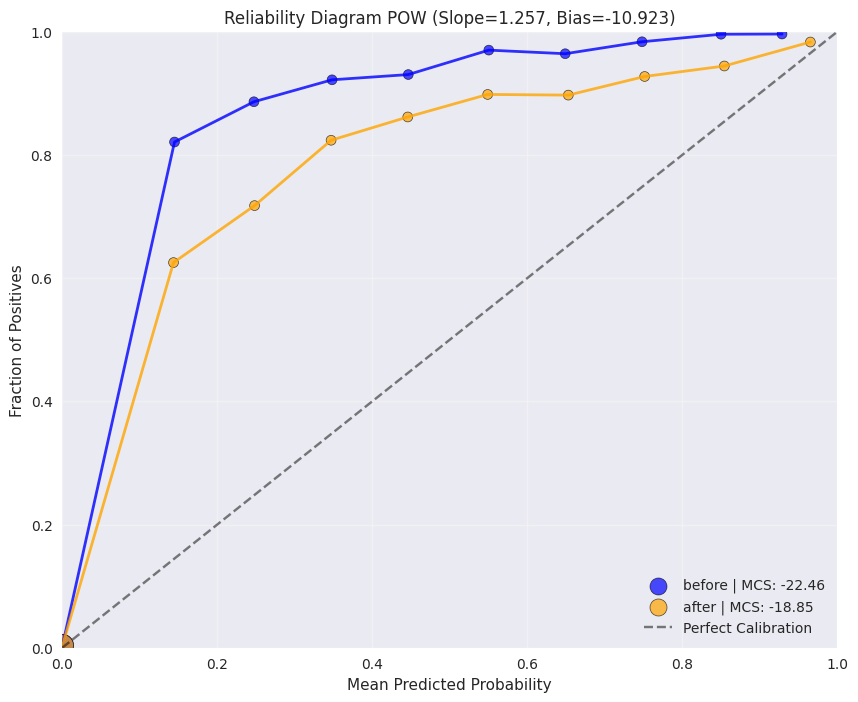

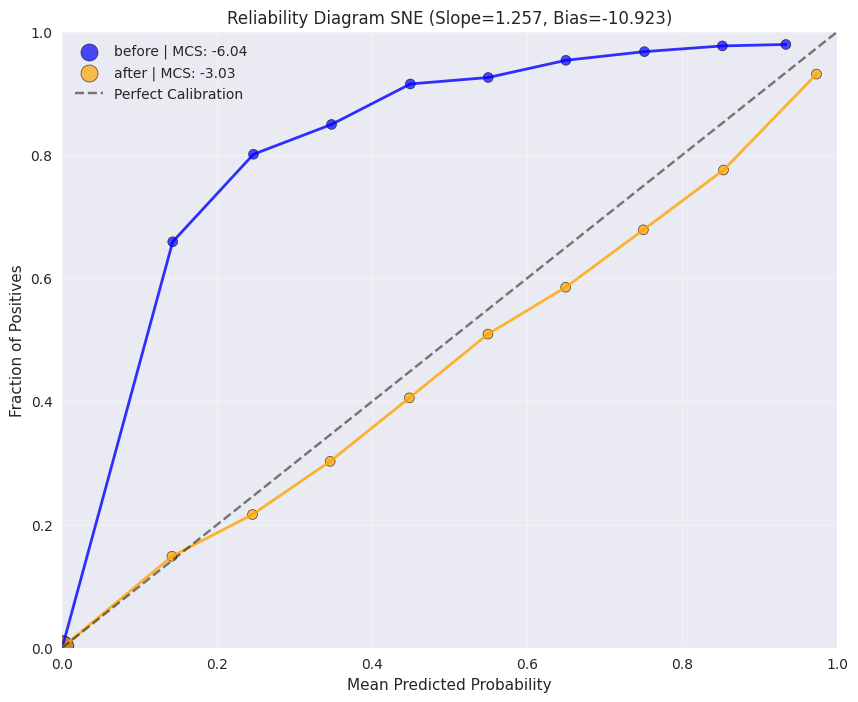

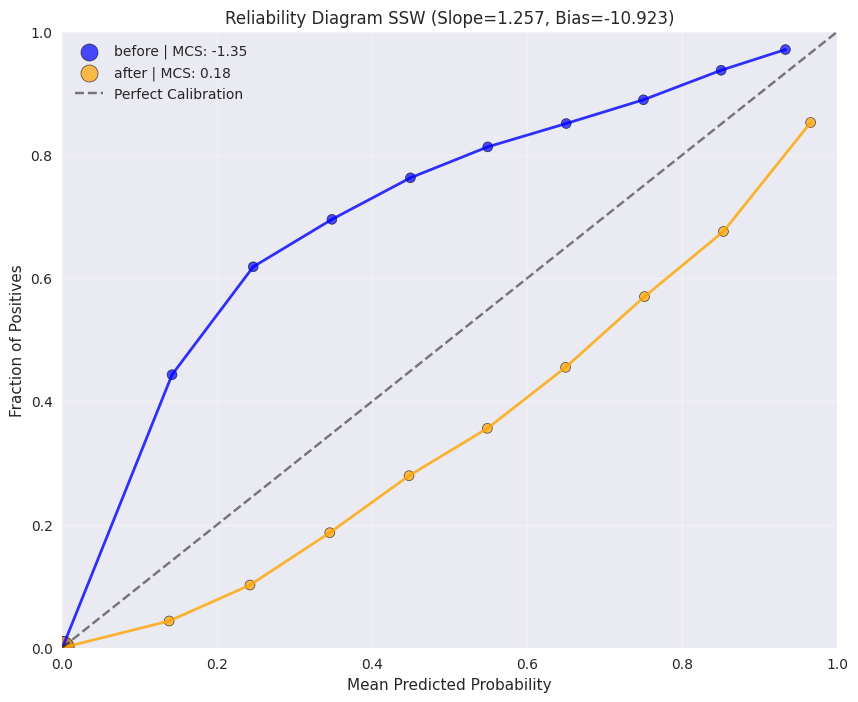

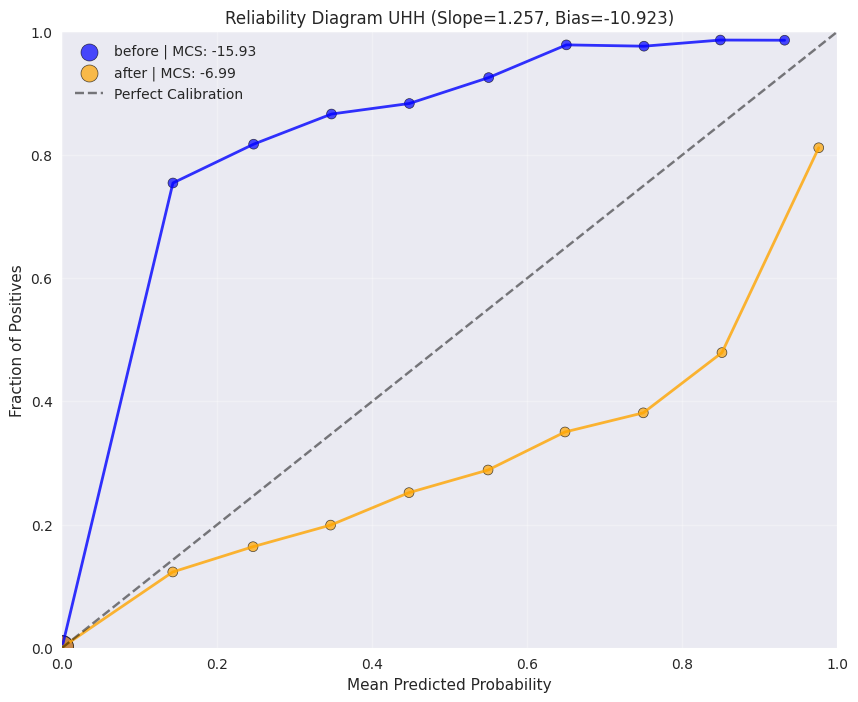

In [14]:
# compute metrics for HSN_test after temperature scaling
from uncertainbird.utils.plotting import (
    plot_combined_reliability_diagram,
    print_metrics,
)


for dataset_name in valid_keys:
    print("Dataset:", dataset_name)
    print("Before platt scaling:")
    data_POW[dataset_name]["metrics"] = print_metrics(
        data_POW[dataset_name]["predictions"], data_POW[dataset_name]["targets"]
    )
    print("After temperature scaling:")
    data_POW[dataset_name]["metrics_ts"] = print_metrics(
        data_POW[dataset_name]["predictions_ts"], data_POW[dataset_name]["targets"]
    )
    # reliability diagram after temperature scaling including before and after
    combined_data = {
        "before": {
            "predictions": data_POW[dataset_name]["predictions"],
            "targets": data_POW[dataset_name]["targets"],
            "color": "blue",
            "metrics": data_POW[dataset_name]["metrics"],
        },
        "after": {
            "predictions": data_POW[dataset_name]["predictions_ts"],
            "targets": data_POW[dataset_name]["targets"],
            "color": "orange",
            "metrics": data_POW[dataset_name]["metrics_ts"],
        },
    }
    plot_combined_reliability_diagram(
        combined_data,
        n_bins=10,
        title=f"Reliability Diagram {dataset_name} (Slope={slope:.3f}, Bias={bias:.3f})",
    )

# Platt scaling using a porton of the test data

In [15]:
from uncertainbird.utils.misc import slit_based_on_first_n_samples

# 10min of audio per class -> 120 samples of 5s each
data_120 = slit_based_on_first_n_samples(data, n=120)

## Global parameters for all classes

### Temperature scaling

In [16]:
for ds in valid_keys:

    # compute global temperature value based on POW
    temperature = fit_global_temperature(
        data[ds+'_cal']["logits"], data_120[ds+'_cal']["targets"], 1000, lr=0.01
    )

    print(f"Optimal temperature: {temperature:.3f} for {ds}")

    data_120[ds+'_test']["predictions_ts"] = apply_temperature_scaling(
        data_120[ds+'_test']["logits"], temperature, model= model
    )
    print('Before temperature scaling:')
    data_120[ds+'_test']["metrics"] = print_metrics(
        data_120[ds+'_test']["predictions"], data_120[ds+'_test']["targets"]
    )
    print('After temperature scaling:')
    data_120[ds+'_test']["metrics_ts"] = print_metrics(
        data_120[ds+'_test']["predictions_ts"], data_120[ds+'_test']["targets"]
    )

Optimal temperature: 2.112 for HSN
Before temperature scaling:
Accuracy: tensor(0.9988)
cmAP: tensor(0.5073)
Precision: tensor(0.0267)
Recall: tensor(0.0042)
F1 Score: tensor(0.0068)
AUROC: tensor(0.0454)
ECE: tensor(0.0011)
ECE Weighted: tensor(0.1090)
ECE Top-3: tensor(0.1097)
ECE Top-5: tensor(0.0814)
ECE Top-10: tensor(0.0441)
ECE Top-21: tensor(0.0215)
Miscalibration Score (MCS): tensor(-0.1089)
ECE Under-confidence: tensor(0.1090)
ECE Over-confidence: tensor(5.1814e-05)
After temperature scaling:
Accuracy: tensor(0.9989)
cmAP: tensor(0.5134)
Precision: tensor(0.0297)
Recall: tensor(0.0102)
F1 Score: tensor(0.0131)
AUROC: tensor(0.0444)
ECE: tensor(0.0024)
ECE Weighted: tensor(0.0754)
ECE Top-3: tensor(0.0662)
ECE Top-5: tensor(0.0529)
ECE Top-10: tensor(0.0512)
ECE Top-21: tensor(0.0453)
Miscalibration Score (MCS): tensor(-0.0618)
ECE Under-confidence: tensor(0.0686)
ECE Over-confidence: tensor(0.0068)
Optimal temperature: 3.223 for NBP
Before temperature scaling:
Accuracy: tenso

Accuracy: tensor(0.9989)
cmAP: tensor(0.3995)
Precision: tensor(0.)
Recall: tensor(0.)
F1 Score: tensor(0.)
AUROC: tensor(0.2016)
ECE: tensor(0.0024)
ECE Weighted: tensor(0.0223)
ECE Top-3: tensor(0.0439)
ECE Top-5: tensor(0.0310)
ECE Top-10: tensor(0.0196)
ECE Top-21: tensor(0.0128)
Miscalibration Score (MCS): tensor(-0.0164)
ECE Under-confidence: tensor(0.0194)
ECE Over-confidence: tensor(0.0030)
Optimal temperature: 4.245 for PER
Before temperature scaling:
Accuracy: tensor(0.9942)
cmAP: tensor(0.2273)
Precision: tensor(0.0985)
Recall: tensor(0.0040)
F1 Score: tensor(0.0073)
AUROC: tensor(0.2474)
ECE: tensor(0.0054)
ECE Weighted: tensor(0.1098)
ECE Top-3: tensor(0.2151)
ECE Top-5: tensor(0.1701)
ECE Top-10: tensor(0.1135)
ECE Top-21: tensor(0.0754)
Miscalibration Score (MCS): tensor(-0.1093)
ECE Under-confidence: tensor(0.1095)
ECE Over-confidence: tensor(0.0002)
After temperature scaling:
Accuracy: tensor(0.9941)
cmAP: tensor(0.2278)
Precision: tensor(0.)
Recall: tensor(0.)
F1 Scor

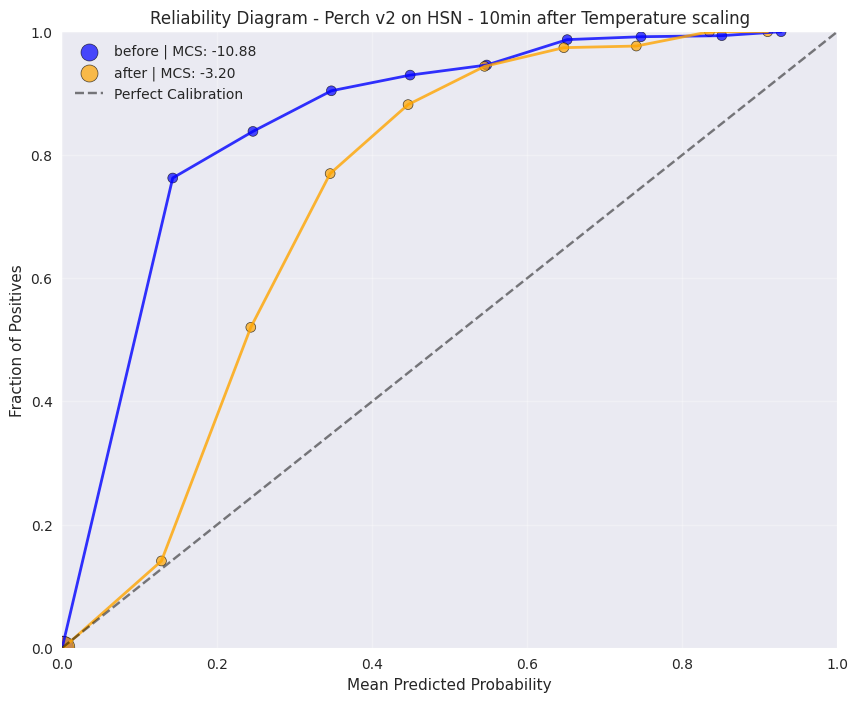

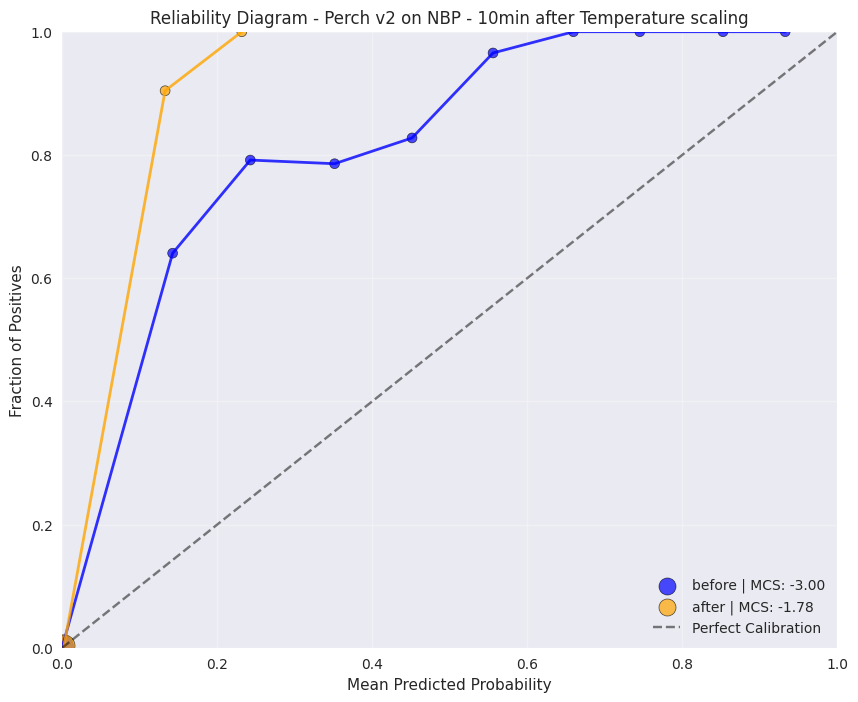

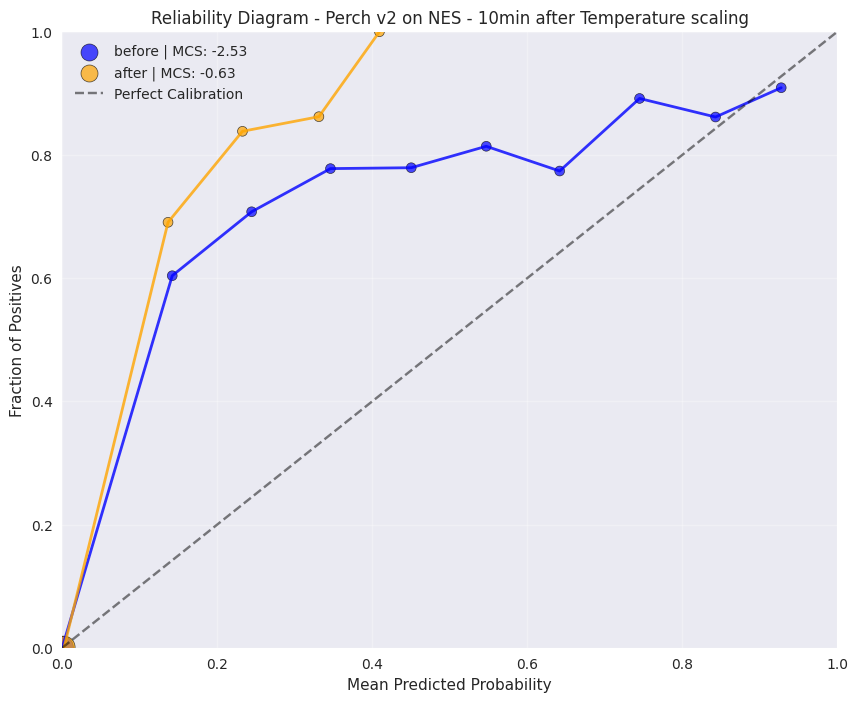

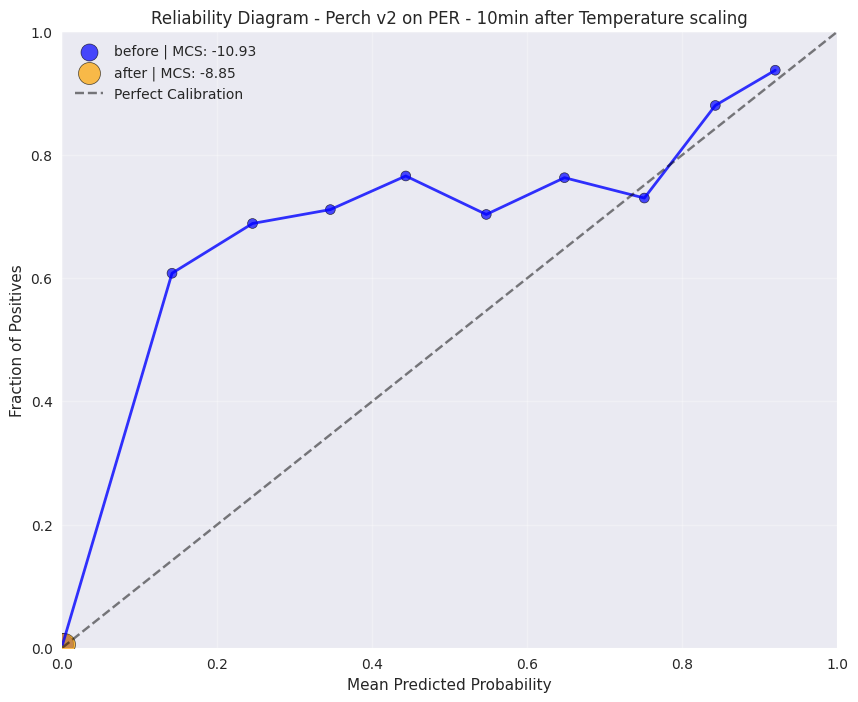

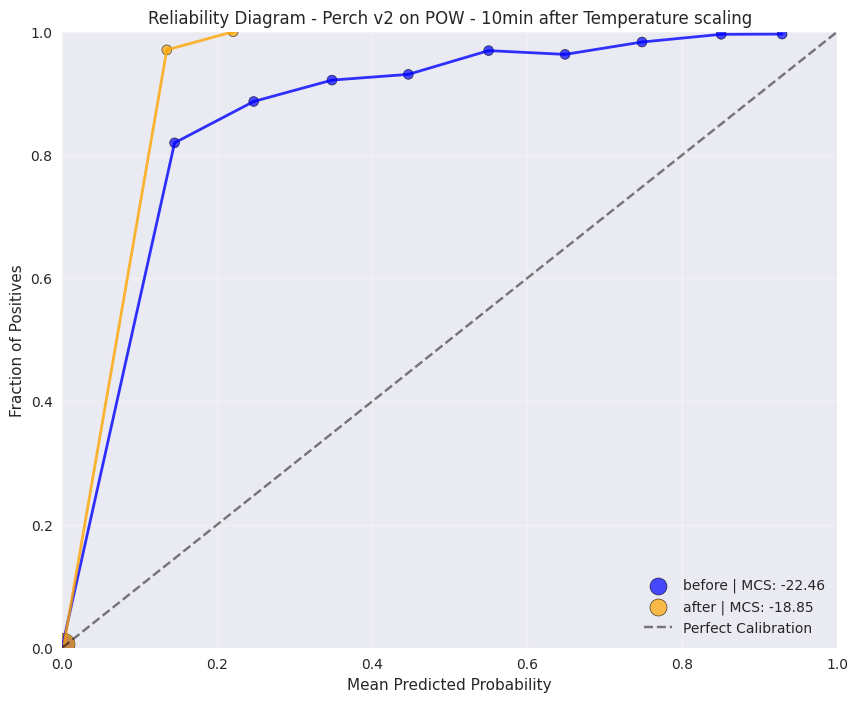

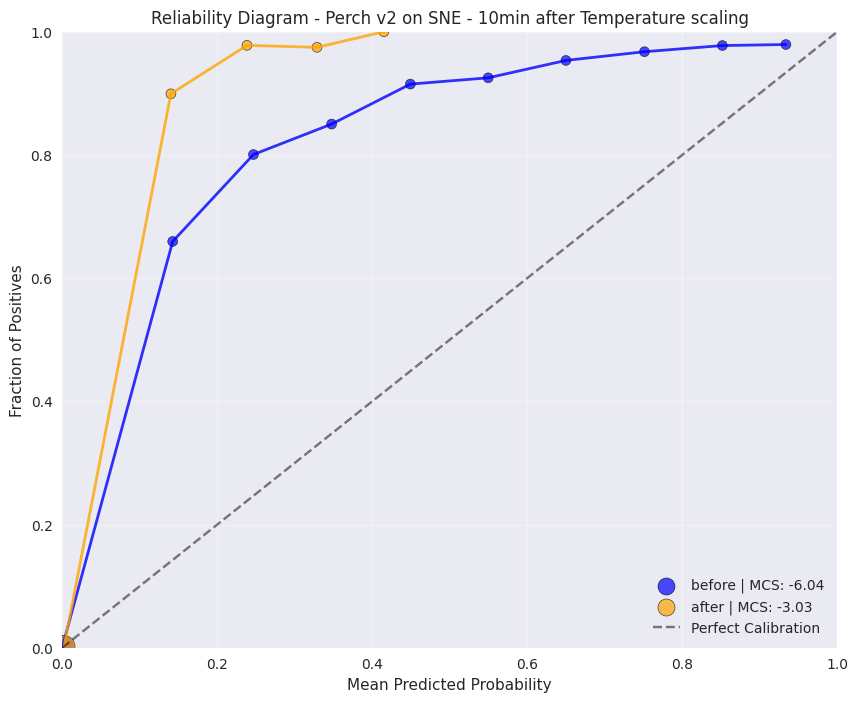

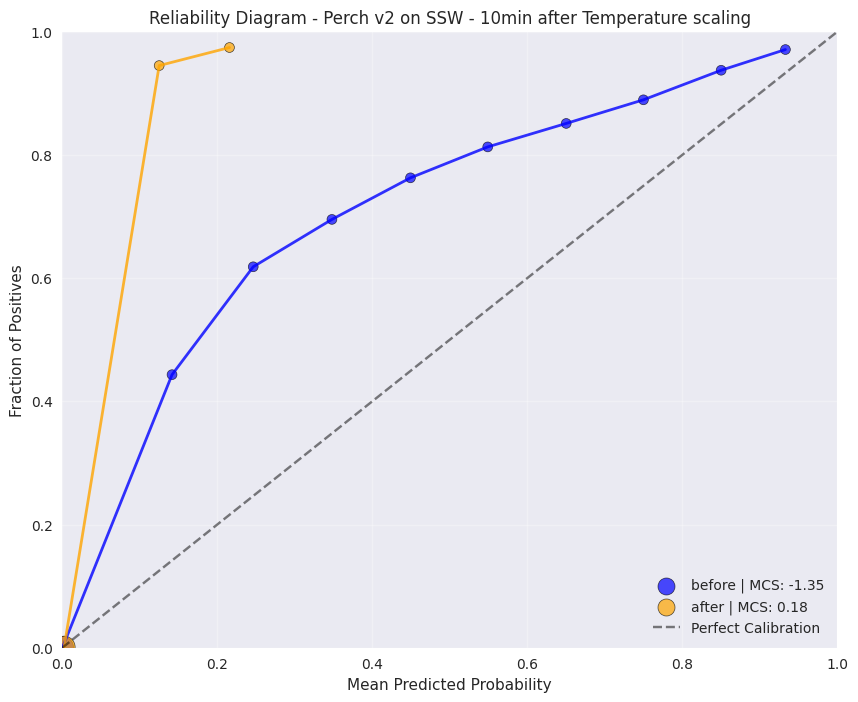

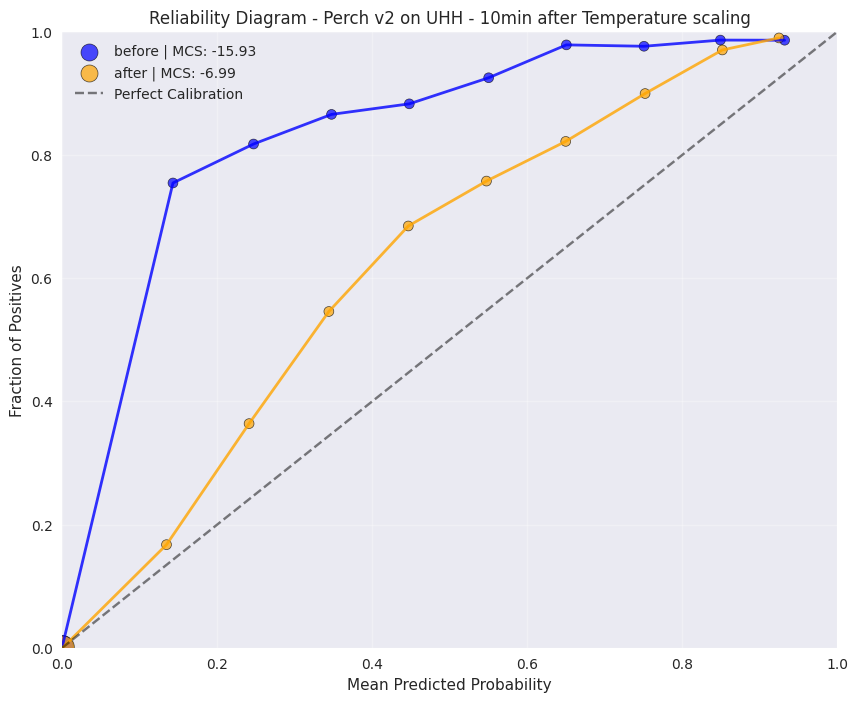

In [ ]:
# compute metrics for HSN_test after temperature scaling
from uncertainbird.utils.plotting import (
    plot_combined_reliability_diagram,
)


for dataset_name in valid_keys:
    # reliability diagram after temperature scaling including before and after
    combined_data = {
        "before": {
            "predictions": data[dataset_name + "_test"]["predictions"],
            "targets": data_120[dataset_name + "_test"]["targets"],
            "color": "blue",
            "metrics": data_120[dataset_name + "_test"]["metrics"],
        },
        "after": {
            "predictions": data_120[dataset_name + "_test"]["predictions_ts"],
            "targets": data_120[dataset_name + "_test"]["targets"],
            "color": "orange",
            "metrics": data_120[dataset_name + "_test"]["metrics_ts"],
        },
    }
    plot_combined_reliability_diagram(
        combined_data,
        n_bins=10,
        title=f"Reliability Diagram - {model_name} on {dataset_name} - 10min after Temperature scaling",
    )

### Platt scaling

In [ ]:
from uncertainbird.utils.temperature_scaling import fit_per_class_platt_scaling


for ds in valid_keys:

    # compute global temperature value based on POW
    slopes, biases = fit_per_class_platt_scaling(
        data[ds+'_cal']["logits"], data_120[ds+'_cal']["targets"], 1000, lr=0.01
    )

    print(f"Optimal slopes: {slopes}, biases: {biases} for {ds}")

    data_120[ds+'_test']["predictions_ts"] = apply_platt_scaling(
        data_120[ds+'_test']["logits"], slopes, biases, model= model
    )
    print('Before platt scaling:')
    data_120[ds+'_test']["metrics"] = print_metrics(
        data_120[ds+'_test']["predictions"], data_120[ds+'_test']["targets"]
    )
    print('After platt scaling:')
    data_120[ds+'_test']["metrics_ts"] = print_metrics(
        data_120[ds+'_test']["predictions_ts"], data_120[ds+'_test']["targets"]
    )

Optimal slopes: tensor([ 1.6465,  1.6465,  1.6465,  1.6465,  1.6465,  1.6465,  1.6465,  1.6465,
         1.6465,  1.6465,  1.6465, -0.8799,  1.6465,  1.6465,  1.6465,  1.6465,
         1.6465,  1.6465,  1.6465,  1.6465,  1.6465,  1.6465,  1.6465,  1.6465,
         1.6465,  1.6465,  1.6465,  1.6465,  1.6465,  1.6465,  1.6465,  1.6465,
         1.6465,  1.6465,  1.6465,  1.6465,  1.6465,  1.6465,  1.6465,  1.6465,
         1.6465,  1.6465,  1.6465,  1.6465,  1.6465,  1.6465,  1.6465,  1.6465,
         1.6465,  1.6465,  1.6465,  1.6465, -1.0780,  1.6465,  1.6465,  1.6465,
         1.6465,  1.6465,  1.6465,  1.6465,  1.6465,  1.6465,  1.6465,  1.6465,
         1.6465,  1.6465,  1.6465,  1.6465,  1.6465,  1.6465,  1.6465,  1.6465,
         1.6465,  1.6465,  1.6465,  1.6465,  1.6465,  1.6465,  1.6465,  1.6465,
         1.6465,  1.6465,  1.6465,  1.6465,  1.6465,  1.6465,  1.6465,  1.6465,
         1.6465,  1.6465,  1.6465,  1.6465,  1.6465,  1.6465,  1.6465,  1.6465,
         1.6465,  1.6465

Accuracy: tensor(0.9943)
cmAP: tensor(0.0581)
Precision: tensor(0.0019)
Recall: tensor(0.0005)
F1 Score: tensor(0.0008)
AUROC: tensor(0.1003)
ECE: tensor(0.0039)
ECE Weighted: tensor(0.0697)
ECE Top-3: tensor(0.1384)
ECE Top-5: tensor(0.1133)
ECE Top-10: tensor(0.0807)
ECE Top-21: tensor(0.0534)
Miscalibration Score (MCS): tensor(-0.0696)
ECE Under-confidence: tensor(0.0697)
ECE Over-confidence: tensor(2.3244e-05)
Optimal slopes: tensor([ 1.6465,  1.6465,  1.6465,  1.6465,  1.6465,  1.6465,  1.6465, -0.8866,
         1.6465,  1.6465,  1.6465,  1.6465,  1.6465,  1.6465,  1.6465,  1.6465,
         1.6465,  1.6465,  1.6465, -0.9224,  1.6465,  1.6465,  1.6465,  1.6465,
         1.6465,  1.6465,  1.6465,  1.6465,  1.6465,  1.6465,  1.6465,  1.6465,
         1.6465, -0.3791,  1.6465,  1.6465,  1.6465,  1.6465,  1.6465,  1.6465,
         1.6465,  1.6465,  1.6465,  1.6465,  1.6465,  1.6465,  1.6465,  1.6465,
         1.6465, -1.3102,  1.6465,  1.6465,  1.6465,  1.6465,  1.6465,  1.6465,
      

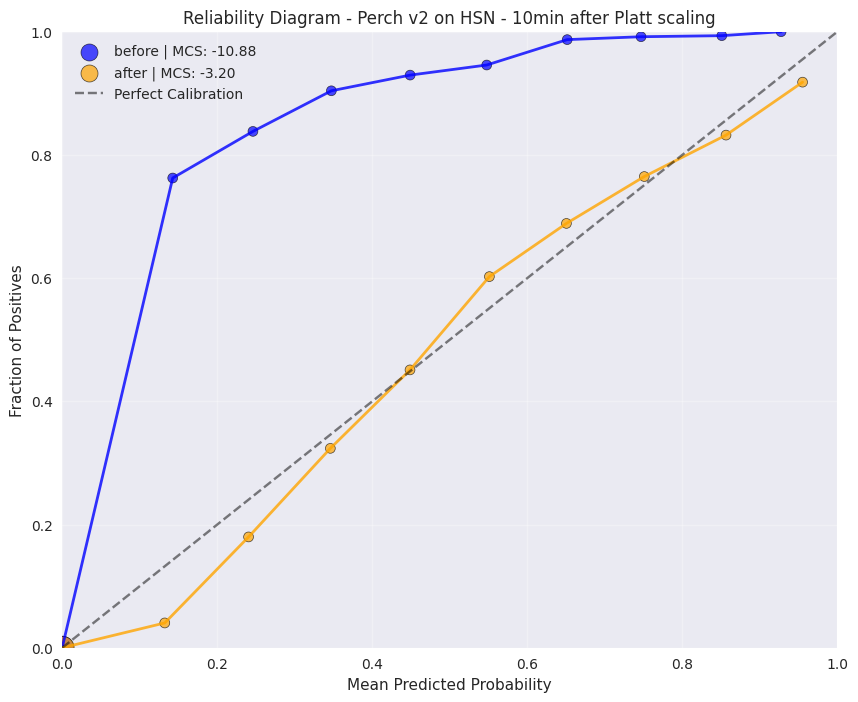

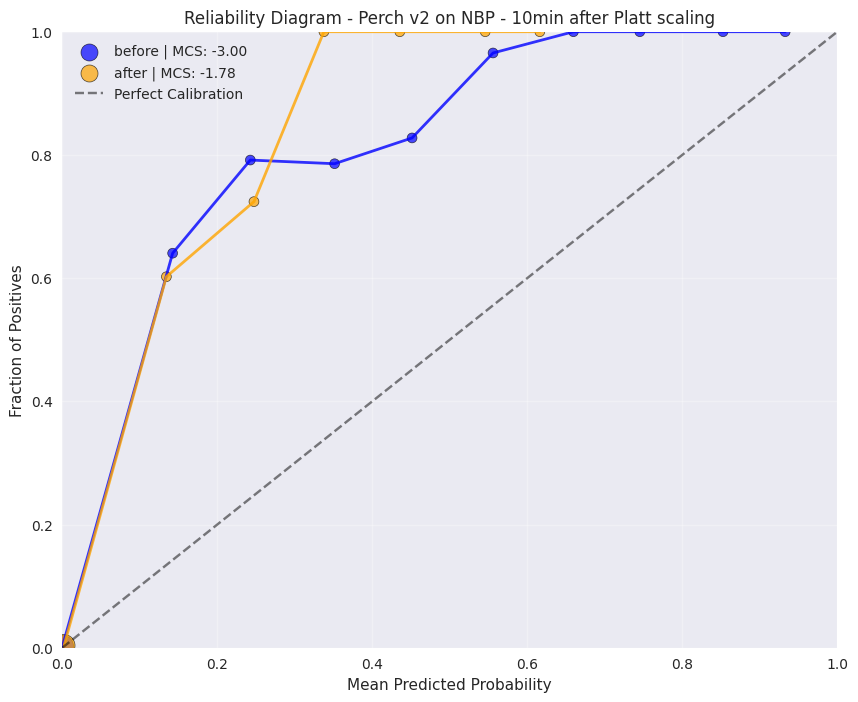

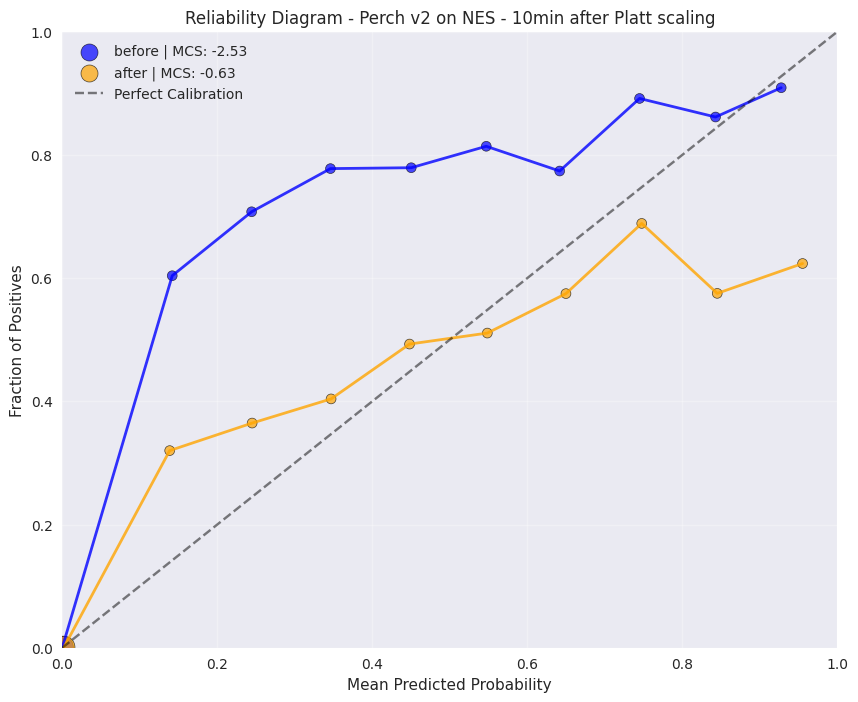

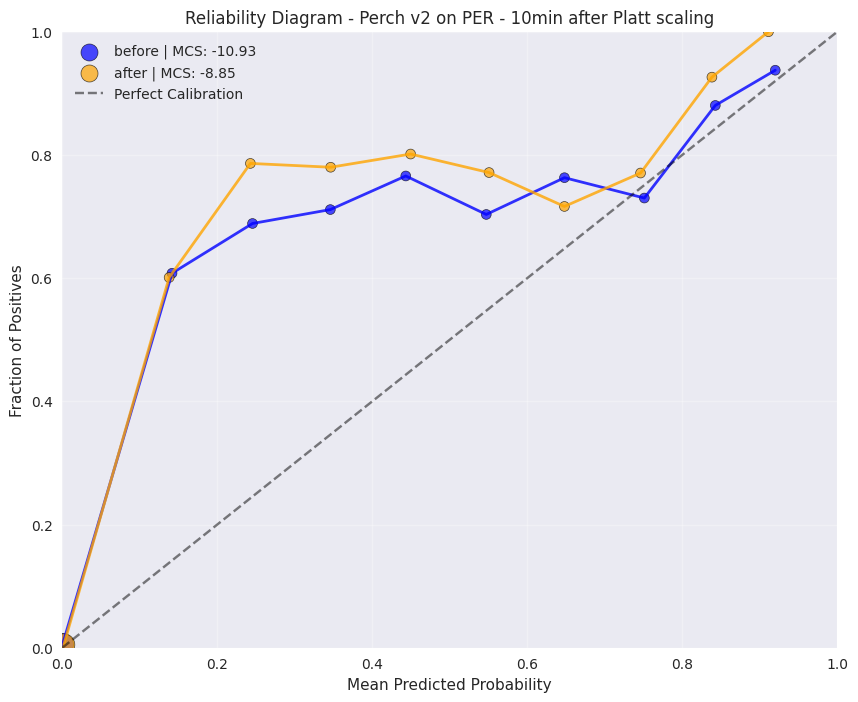

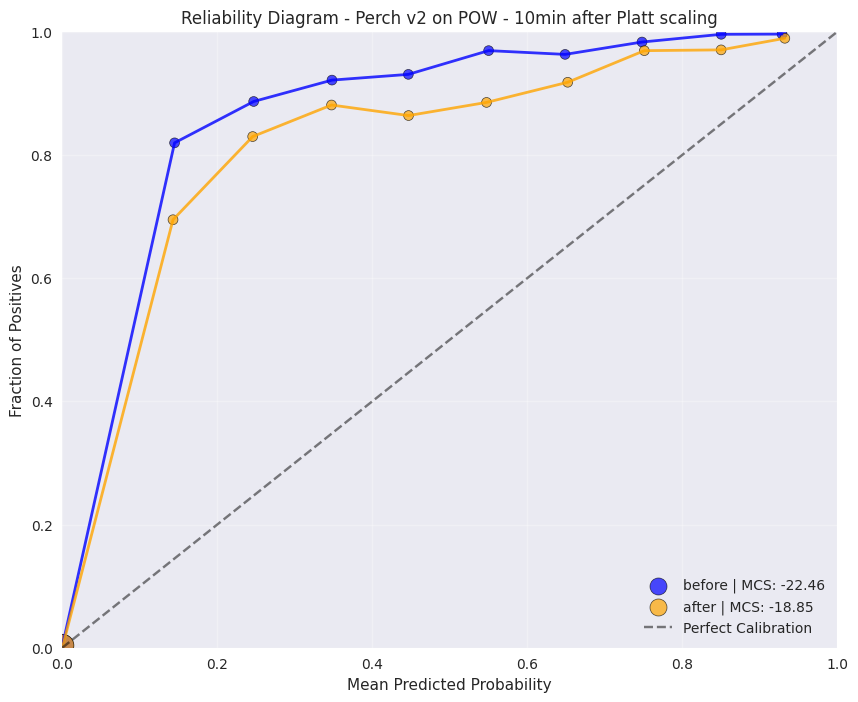

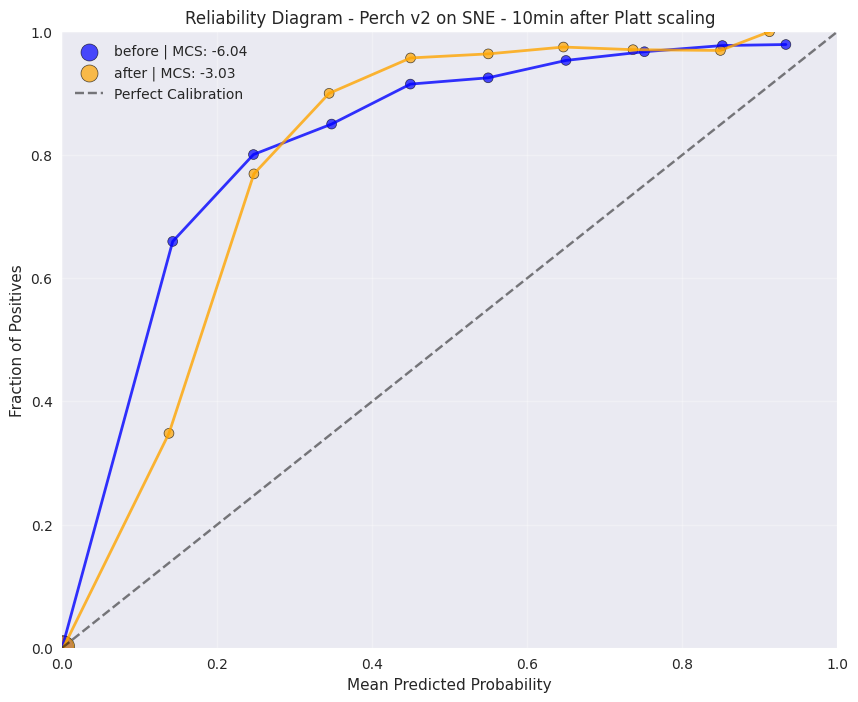

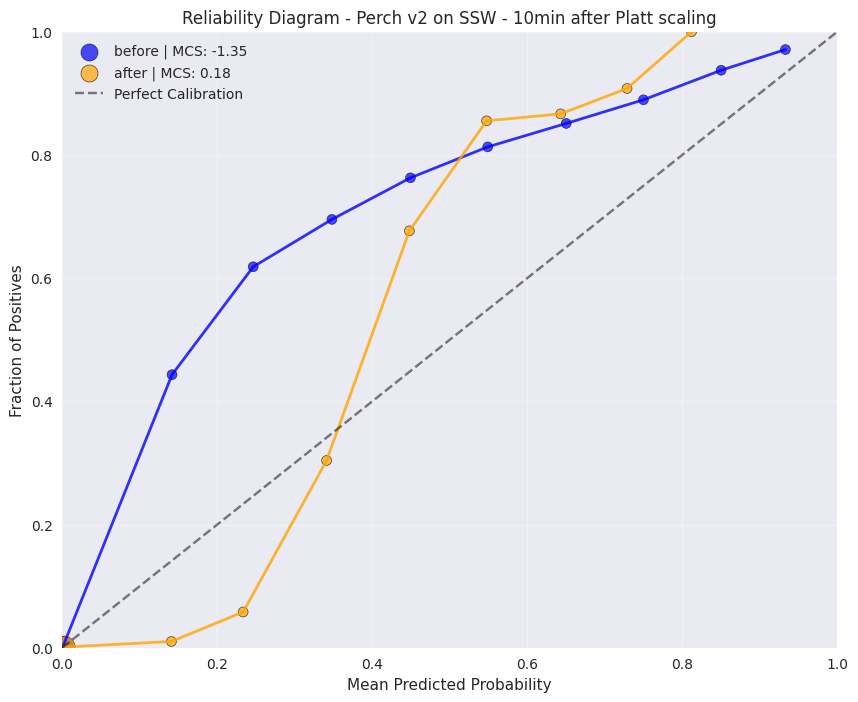

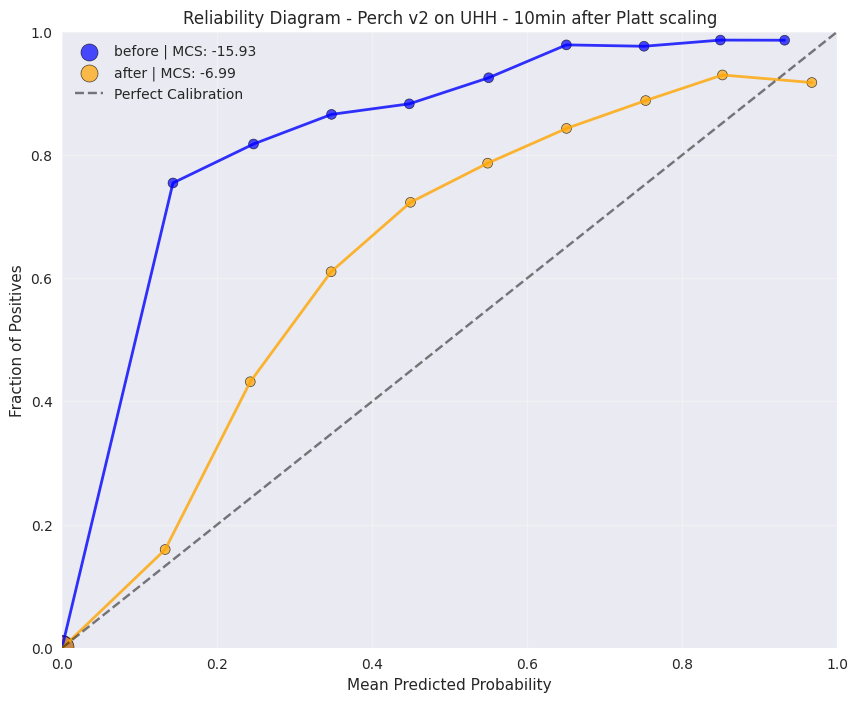

In [ ]:
# compute metrics for HSN_test after temperature scaling
from uncertainbird.utils.plotting import (
    plot_combined_reliability_diagram,
)


for dataset_name in valid_keys:
    # reliability diagram after temperature scaling including before and after
    combined_data = {
        "before": {
            "predictions": data[dataset_name + "_test"]["predictions"],
            "targets": data_120[dataset_name + "_test"]["targets"],
            "color": "blue",
            "metrics": data_120[dataset_name + "_test"]["metrics"],
        },
        "after": {
            "predictions": data_120[dataset_name + "_test"]["predictions_ts"],
            "targets": data_120[dataset_name + "_test"]["targets"],
            "color": "orange",
            "metrics": data_120[dataset_name + "_test"]["metrics_ts"],
        },
    }
    plot_combined_reliability_diagram(
        combined_data,
        n_bins=10,
        title=f"Reliability Diagram - {model_name} on {dataset_name} - 10min after Platt scaling",
    )

## Parameters per class

### Temperature scaling

In [ ]:
from uncertainbird.utils.temperature_scaling import fit_per_class_temperatures


for ds in valid_keys:

    print(f"Fit temperatures per class for {ds}")
    # compute global temperature value based on POW
    temperatures = fit_per_class_temperatures(
        data[ds+'_cal']["logits"], data_120[ds+'_cal']["targets"], 1000, lr=0.01
    )


    data_120[ds+'_test']["predictions_ts"] = apply_temperature_scaling(
        data_120[ds+'_test']["logits"], temperatures, model= model
    )
    print('After temperature scaling:')
    data_120[ds+'_test']["metrics_ts"] = print_metrics(
        data_120[ds+'_test']["predictions_ts"], data_120[ds+'_test']["targets"]
    )

Fit temperatures per class for HSN
Before temperature scaling:
Accuracy: tensor(0.9988)
cmAP: tensor(0.5073)
Precision: tensor(0.0267)
Recall: tensor(0.0042)
F1 Score: tensor(0.0068)
AUROC: tensor(0.0454)
ECE: tensor(0.0011)
ECE Weighted: tensor(0.1090)
ECE Top-3: tensor(0.1097)
ECE Top-5: tensor(0.0814)
ECE Top-10: tensor(0.0441)
ECE Top-21: tensor(0.0215)
Miscalibration Score (MCS): tensor(-0.1089)
ECE Under-confidence: tensor(0.1090)
ECE Over-confidence: tensor(5.1814e-05)
After temperature scaling:
Accuracy: tensor(0.9987)
cmAP: tensor(0.5078)
Precision: tensor(0.)
Recall: tensor(0.)
F1 Score: tensor(0.)
AUROC: tensor(0.0449)
ECE: tensor(0.0023)
ECE Weighted: tensor(0.0886)
ECE Top-3: tensor(0.0763)
ECE Top-5: tensor(0.0518)
ECE Top-10: tensor(0.0449)
ECE Top-21: tensor(0.0456)
Miscalibration Score (MCS): tensor(-0.0778)
ECE Under-confidence: tensor(0.0832)
ECE Over-confidence: tensor(0.0054)
Fit temperatures per class for NBP
Before temperature scaling:
Accuracy: tensor(0.9966)
cm

Accuracy: tensor(0.9973)
cmAP: tensor(0.3347)
Precision: tensor(0.)
Recall: tensor(0.)
F1 Score: tensor(0.)
AUROC: tensor(0.1192)
ECE: tensor(0.0033)
ECE Weighted: tensor(0.0709)
ECE Top-3: tensor(0.1250)
ECE Top-5: tensor(0.1002)
ECE Top-10: tensor(0.0686)
ECE Top-21: tensor(0.0380)
Miscalibration Score (MCS): tensor(-0.0690)
ECE Under-confidence: tensor(0.0699)
ECE Over-confidence: tensor(0.0009)
Fit temperatures per class for SSW
Before temperature scaling:
Accuracy: tensor(0.9992)
cmAP: tensor(0.4525)
Precision: tensor(0.1339)
Recall: tensor(0.0420)
F1 Score: tensor(0.0553)
AUROC: tensor(0.1877)
ECE: tensor(0.0007)
ECE Weighted: tensor(0.0137)
ECE Top-3: tensor(0.0288)
ECE Top-5: tensor(0.0238)
ECE Top-10: tensor(0.0154)
ECE Top-21: tensor(0.0099)
Miscalibration Score (MCS): tensor(-0.0135)
ECE Under-confidence: tensor(0.0136)
ECE Over-confidence: tensor(0.0001)
After temperature scaling:
Accuracy: tensor(0.9989)
cmAP: tensor(0.4759)
Precision: tensor(0.)
Recall: tensor(0.)
F1 Scor

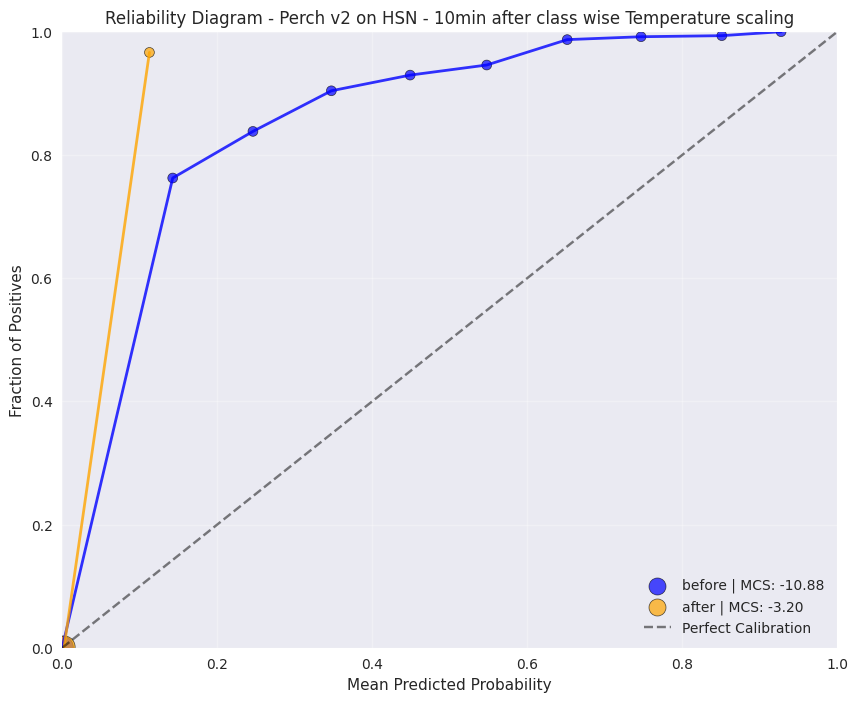

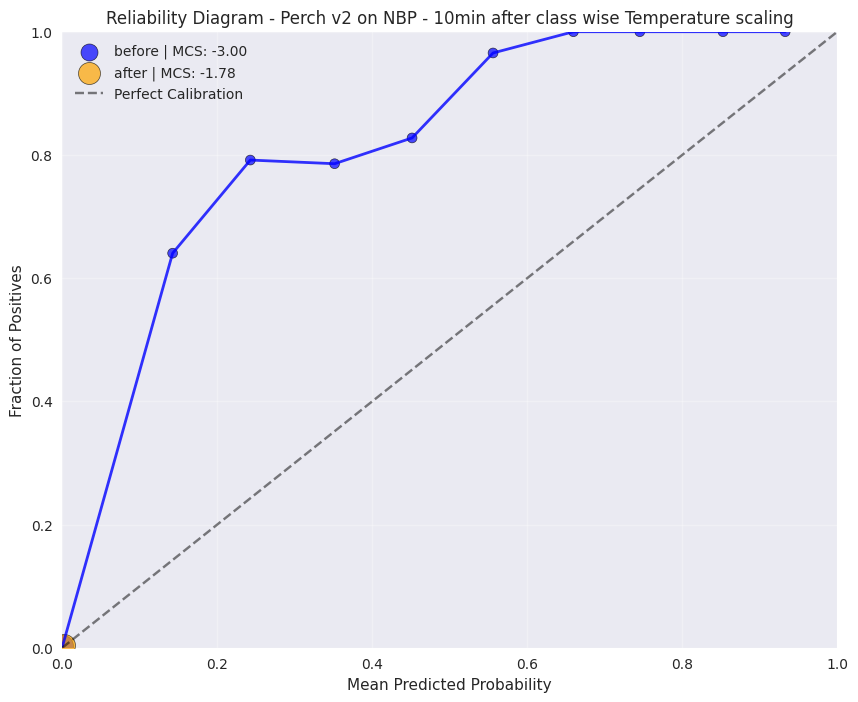

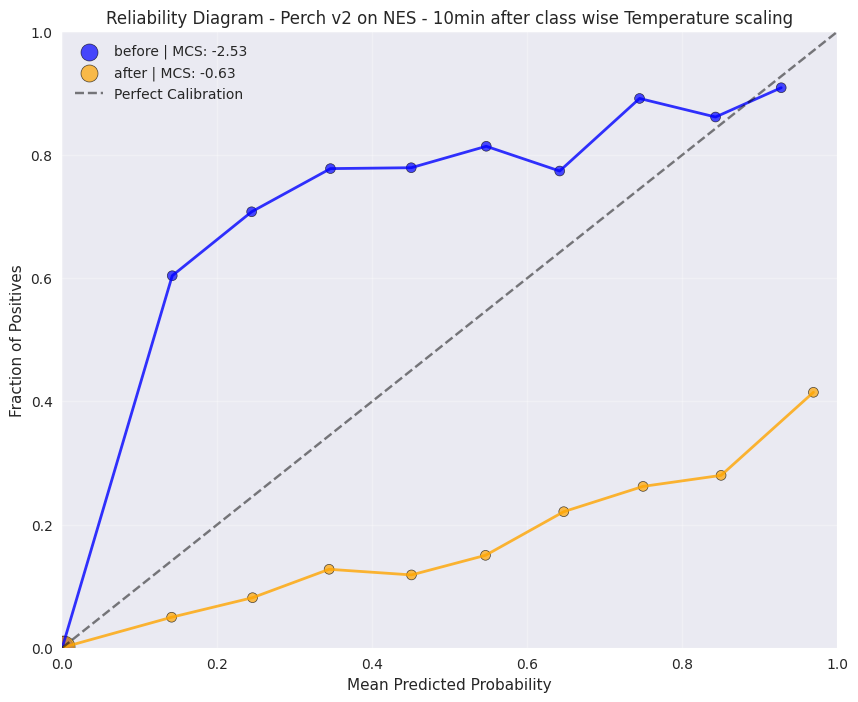

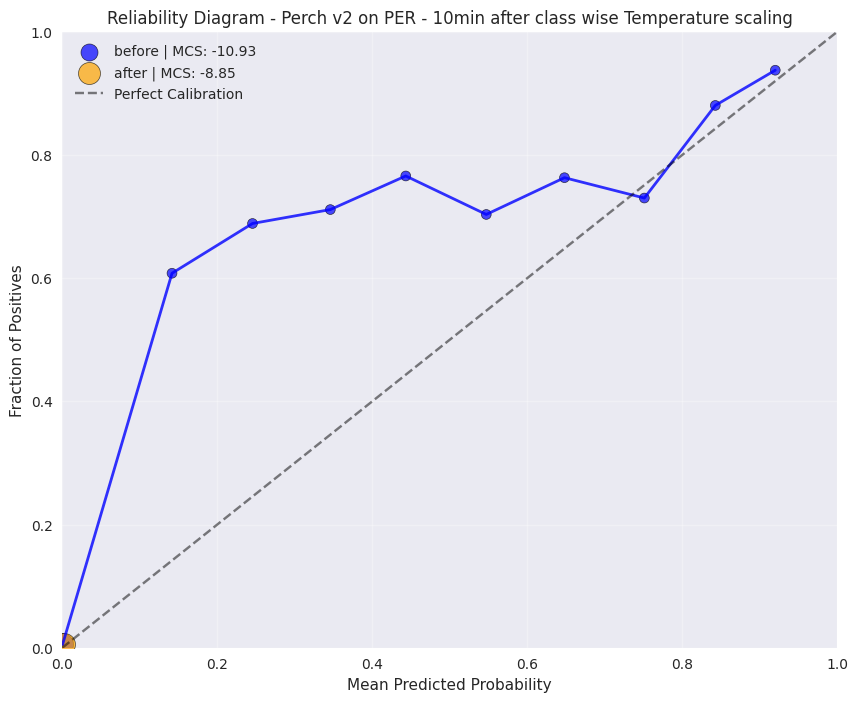

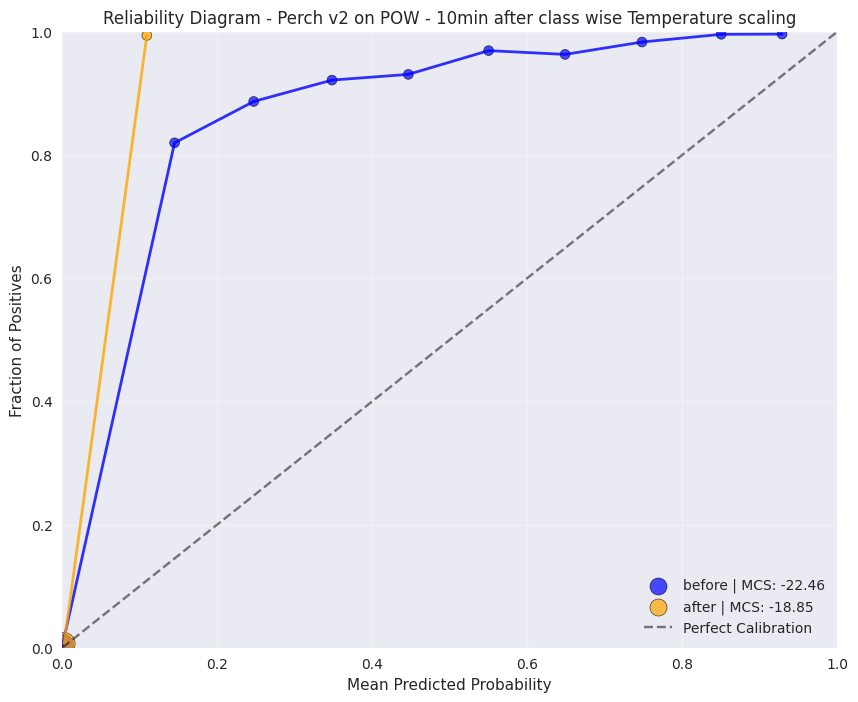

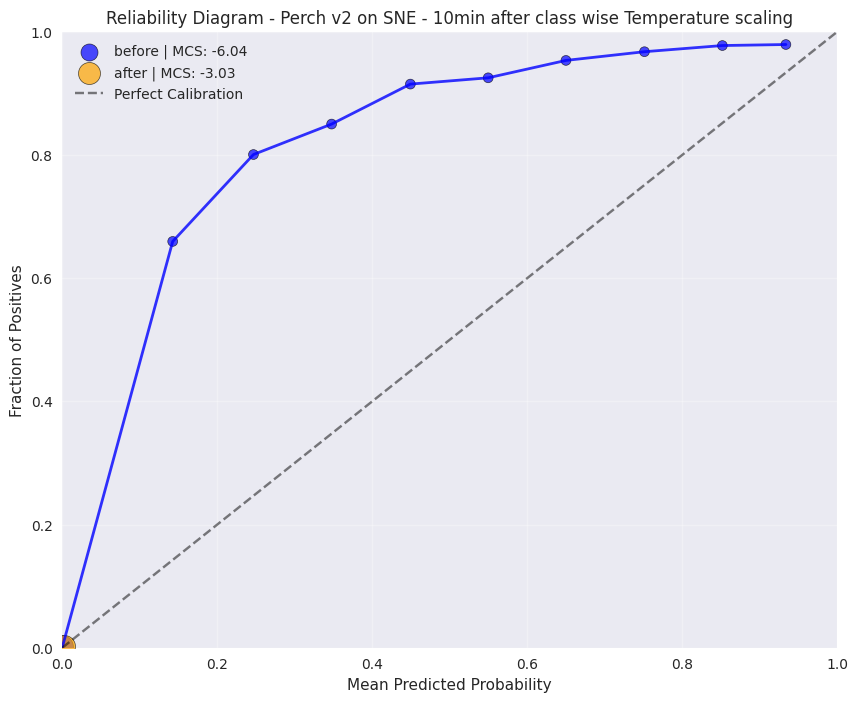

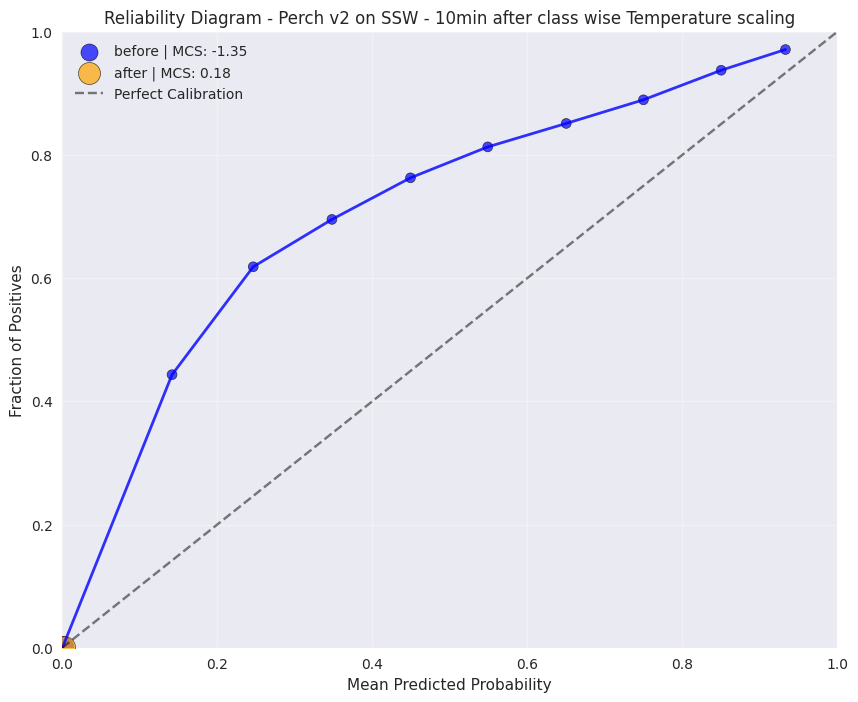

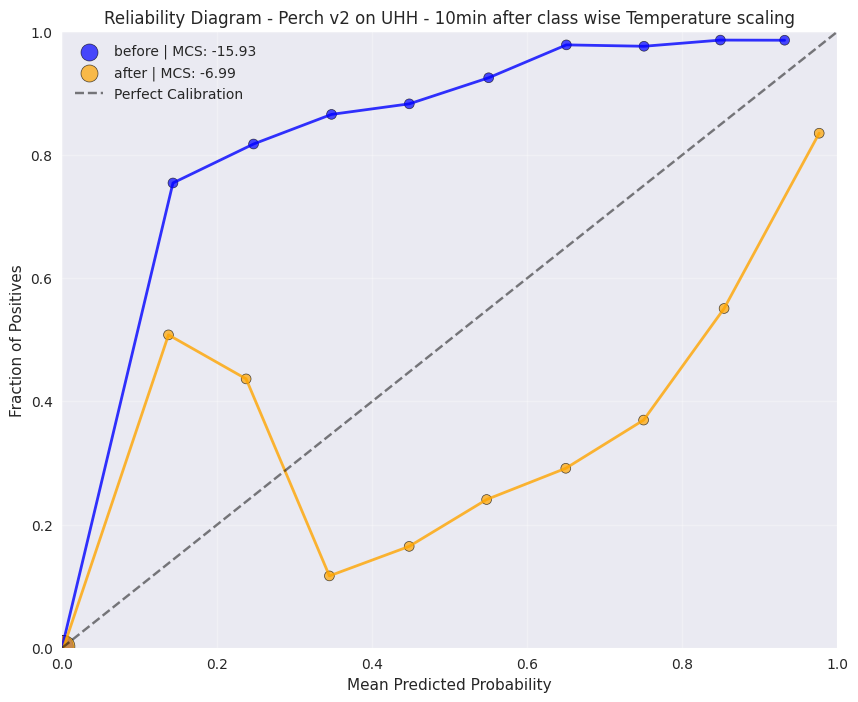

In [ ]:
# compute metrics for HSN_test after temperature scaling
from uncertainbird.utils.plotting import (
    plot_combined_reliability_diagram,
)


for dataset_name in valid_keys:
    # reliability diagram after temperature scaling including before and after
    combined_data = {
        "before": {
            "predictions": data[dataset_name + "_test"]["predictions"],
            "targets": data_120[dataset_name + "_test"]["targets"],
            "color": "blue",
            "metrics": data_120[dataset_name + "_test"]["metrics"],
        },
        "after": {
            "predictions": data_120[dataset_name + "_test"]["predictions_ts"],
            "targets": data_120[dataset_name + "_test"]["targets"],
            "color": "orange",
            "metrics": data_120[dataset_name + "_test"]["metrics_ts"],
        },
    }
    plot_combined_reliability_diagram(
        combined_data,
        n_bins=10,
        title=f"Reliability Diagram - {model_name} on {dataset_name} - 10min after class wise Temperature scaling",
    )

### Platt scaling

In [ ]:
from uncertainbird.utils.temperature_scaling import fit_per_class_platt_scaling, apply_platt_scaling
for ds in valid_keys:

    # compute global temperature value based on POW
    slopes, biases = fit_per_class_platt_scaling(
        data[ds+'_cal']["logits"], data_120[ds+'_cal']["targets"], 1000, lr=0.01
    )

    # for i, (slope, bias) in enumerate(zip(slopes, biases)):
    #     print(f"Optimal slope: {slope:.3f}, bias: {bias:.3f} for {ds}, class {i}")

    data_120[ds+'_test']["predictions_ts"] = apply_platt_scaling(
        data_120[ds+'_test']["logits"], slopes, biases, model= model
    )
    print('After platt scaling:')
    data_120[ds+'_test']["metrics_ts"] = print_metrics(
        data_120[ds+'_test']["predictions_ts"], data_120[ds+'_test']["targets"]
    )

Before platt scaling:


/workspace/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in macro-average
  warnings.warn(*args, **kwargs)  # noqa: B028
/workspace/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Accuracy: tensor(0.9988)
cmAP: tensor(0.5073)
Precision: tensor(0.0267)
Recall: tensor(0.0042)
F1 Score: tensor(0.0068)
AUROC: tensor(0.0454)
ECE: tensor(0.0011)
ECE Weighted: tensor(0.1090)
ECE Top-3: tensor(0.1097)
ECE Top-5: tensor(0.0814)
ECE Top-10: tensor(0.0441)
ECE Top-21: tensor(0.0215)
Miscalibration Score (MCS): tensor(-0.1089)
ECE Under-confidence: tensor(0.1090)
ECE Over-confidence: tensor(5.1814e-05)
After platt scaling:
Accuracy: tensor(0.9992)
cmAP: tensor(0.1708)
Precision: tensor(0.0080)
Recall: tensor(0.0057)
F1 Score: tensor(0.0066)
AUROC: tensor(0.0178)
ECE: tensor(0.0013)
ECE Weighted: tensor(0.0535)
ECE Top-3: tensor(0.0534)
ECE Top-5: tensor(0.0489)
ECE Top-10: tensor(0.0379)
ECE Top-21: tensor(0.0261)
Miscalibration Score (MCS): tensor(0.0424)
ECE Under-confidence: tensor(0.0055)
ECE Over-confidence: tensor(0.0480)
Before platt scaling:
Accuracy: tensor(0.9966)
cmAP: tensor(0.6374)
Precision: tensor(0.0994)
Recall: tensor(0.0236)
F1 Score: tensor(0.0356)
AUROC:

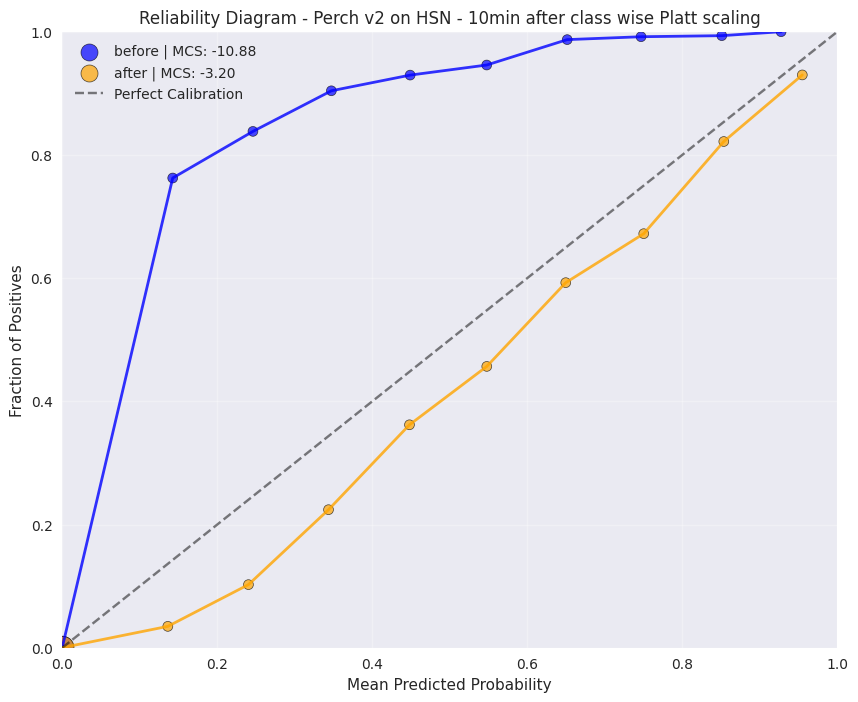

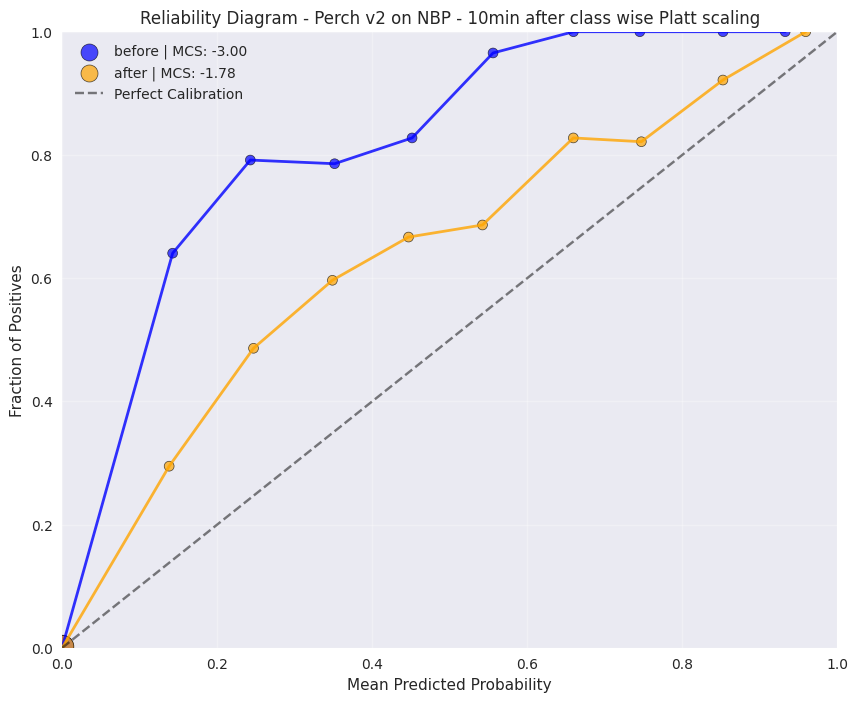

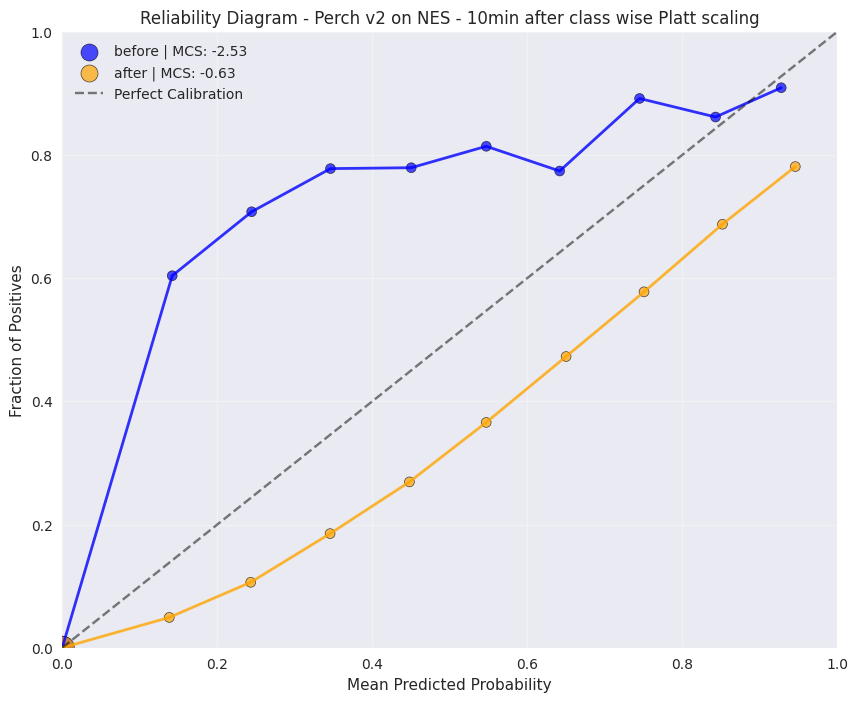

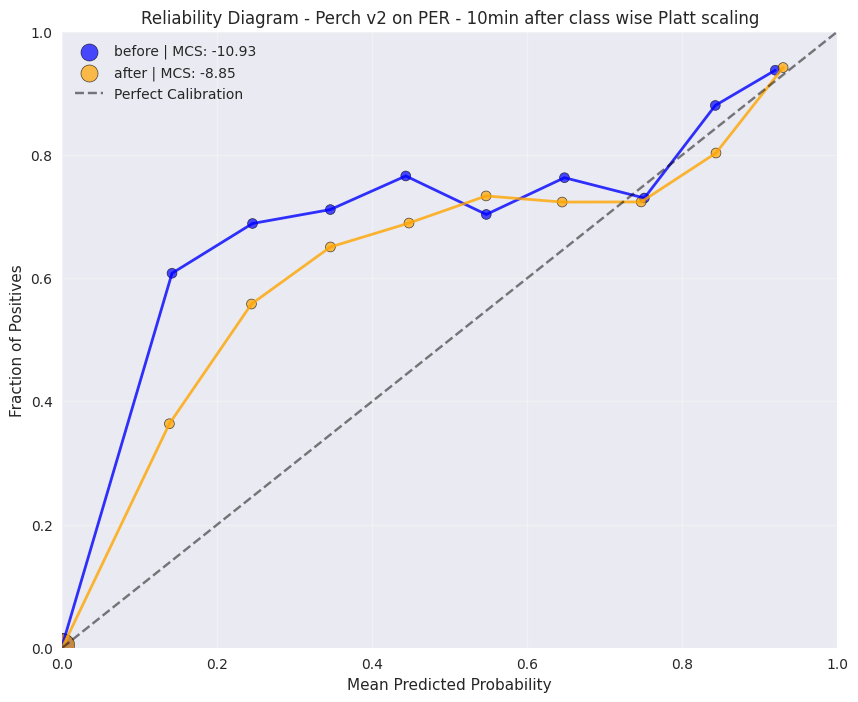

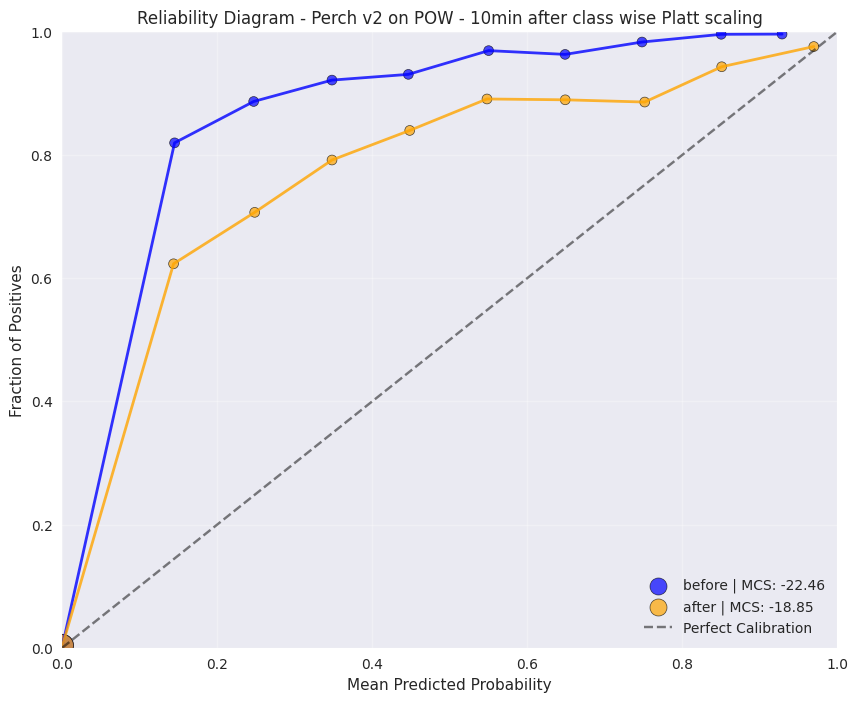

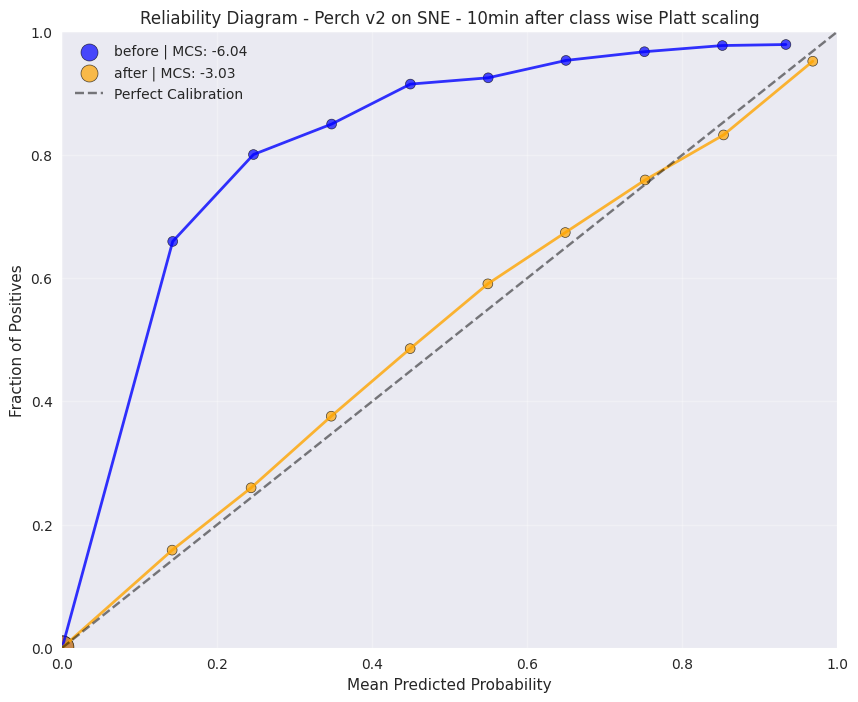

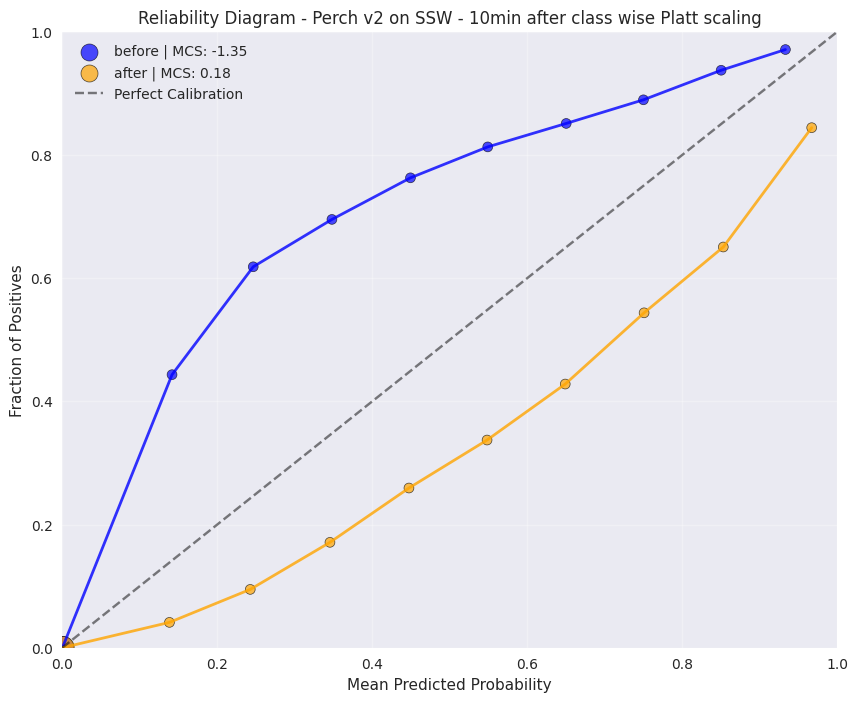

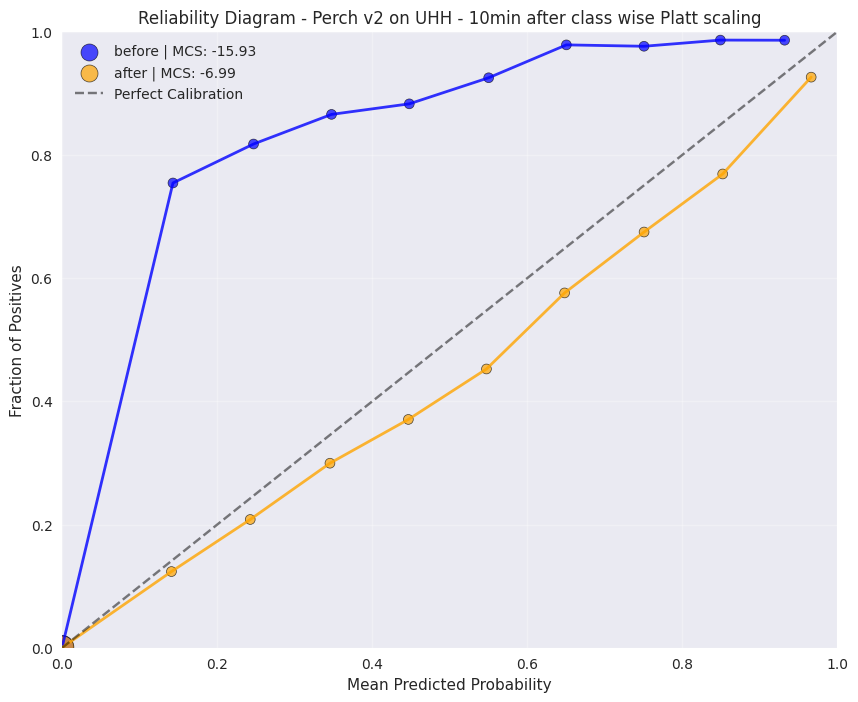

In [ ]:
# compute metrics for HSN_test after temperature scaling
from uncertainbird.utils.plotting import (
    plot_combined_reliability_diagram,
)


for dataset_name in valid_keys:
    # reliability diagram after temperature scaling including before and after
    combined_data = {
        "before": {
            "predictions": data[dataset_name + "_test"]["predictions"],
            "targets": data_120[dataset_name + "_test"]["targets"],
            "color": "blue",
            "metrics": data_120[dataset_name + "_test"]["metrics"],
        },
        "after": {
            "predictions": data_120[dataset_name + "_test"]["predictions_ts"],
            "targets": data_120[dataset_name + "_test"]["targets"],
            "color": "orange",
            "metrics": data_120[dataset_name + "_test"]["metrics_ts"],
        },
    }
    plot_combined_reliability_diagram(
        combined_data,
        n_bins=10,
        title=f"Reliability Diagram - {model_name} on {dataset_name} - 10min after class wise Platt scaling",
    )